In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy

from dataloaders import *
from util import Config
from viz_utils import *

In [2]:
datasets = ["MRPC", "TREC-2", "SUBJ", "AGN-2", "TREC-6", "AGN-4", "SST"]
dataset_map = {
    "TREC-2": "TREC-2",
    "SUBJ": "SUBJ",
    "AGN-2": "AGN-2",
    "TREC-6": "TREC-full",
    "SST": "SST",
    "COLA": "COLA",
    "AGN-4": "ag_news-full",
}
models = ["BERT", "ELECTRA"]
load_anti = False
n = 0  # AL step at which evaluation (AUC) starts
model = "BERT"
mode = "ada"
dataset = "BERT"

aucs = []
trs = []
for tapta in [False]:
    for adapter in ["fft", "unipelt", "lora", "prefix", "houlsby"]:
        try:
            experiments, meta = load_results_multiple(
                base_dir=f"results/exp1/storage",
                dataset=dataset,
                model=model,
                adapter=adapter,
                tapta=tapta,
            )
        except:
            print(f"No experiments for {dataset}-{model}-{mode}")
        for load_mode in ["last", "best"]:
            mode_print = mode if load_mode == "last" else f"{mode}-besov"
            print(f"Loading {dataset} -- {mode_print} -- {model}")
            df_tr_i = results_to_df(experiments, mode=load_mode)

            df_tr_i["model"] = meta["model"] + "-" + adapter + ("-TAPTA" if tapta else "")
            print(meta)
            df_tr_i["mode"] = mode_print
            df_tr_i["dataset"] = dataset
            df_tr_i = df_tr_i.reset_index().set_index(
                ["dataset", "model", "mode", "sampler", "experiment", "al_iter"]
            )
            trs.append(df_tr_i)

            df_auc_i = al_auc(df_tr_i)
            df_auc_i["mode"] = mode_print
            df_auc_i = df_auc_i.reset_index().set_index(["mode", "sampler"])
            aucs.append(df_auc_i)


    # plot_besov_index(df_tr, ci=0)
    # plot_al_accuracy(df_tr, metric="f1_micro", ci=0)
    df_tr = pd.concat(trs)
    df_auc = pd.concat(aucs)

BERT-BERT
No experiments for BERT-BERT-ada
Loading BERT -- ada -- BERT


NameError: name 'experiments' is not defined

In [141]:
datasets = ["MRPC", "TREC-2", "SUBJ", "AGN-2", "TREC-6", "AGN-4", "SST"]
dataset_map = {
    "TREC-2": "TREC-2",
    "SUBJ": "SUBJ",
    "AGN-2": "AGN-2",
    "TREC-6": "TREC-full",
    "SST": "SST",
    "COLA": "COLA",
    "AGN-4": "ag_news-full",
}
models = ["BERT", "ELECTRA"]
load_anti = False
n = 0  # AL step at which evaluation (AUC) starts
model = "BERT"
mode = "ada"
dataset = "SST"

aucs = []
trs = []
try:
    experiments, meta = load_results(
        base_dir=f"results/prefix/tapta",
        dataset=dataset,
        model=model,
    )
except:
    print(f"No experiments for {dataset}-{model}-{mode}")
print(len(experiments))
for load_mode in ["last", "best"]:
    mode_print = mode if load_mode == "last" else f"{mode}-besov"
    print(f"Loading {dataset} -- {mode_print} -- {model}")
    df_tr_i = results_to_df(experiments, mode=load_mode)

    df_tr_i["model"] = meta["model"]
    print(meta)
    df_tr_i["mode"] = mode_print
    df_tr_i["dataset"] = dataset
    df_tr_i = df_tr_i.reset_index().set_index(
        ["dataset", "model", "mode", "sampler", "experiment", "al_iter"]
    )
    trs.append(df_tr_i)

    df_auc_i = al_auc(df_tr_i)
    df_auc_i["mode"] = mode_print
    df_auc_i = df_auc_i.reset_index().set_index(["mode", "sampler"])
    aucs.append(df_auc_i)


    # plot_besov_index(df_tr, ci=0)
    # plot_al_accuracy(df_tr, metric="f1_micro", ci=0)
    df_tr = pd.concat(trs)
    df_auc = pd.concat(aucs)

SST-BERT
5
Loading SST -- ada -- BERT
{'dataset': 'SST', 'model': 'BERT', 'warm_start_size': 100, 'query_size': 50, 'batch_size': 32, 'epochs_per_train': 50, 'seeds': [1, 2, 3, 4, 5], 'lr': 0.0001, 'l2': 1e-05, 'time': 58810.946535}
Loading SST -- ada-besov -- BERT
{'dataset': 'SST', 'model': 'BERT', 'warm_start_size': 100, 'query_size': 50, 'batch_size': 32, 'epochs_per_train': 50, 'seeds': [1, 2, 3, 4, 5], 'lr': 0.0001, 'l2': 1e-05, 'time': 58810.946535}


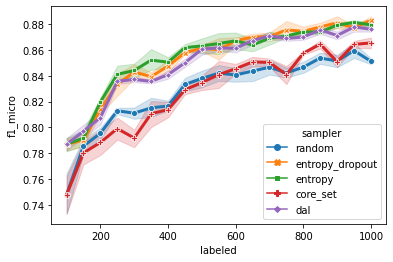

In [142]:
g = sns.lineplot(
    data=df_tr[df_tr.index.get_level_values("mode") == "ada-besov"],
    x="labeled",
    y="f1_micro",
    hue="sampler",
    style="sampler",
    markers=True,
    dashes=False,
    ci=75,
    linewidth=3,
)
# plt.legend(loc='lower right')
# g.set_ylim(0.89, 0.975)
# g.set_xlim(300, 1000)

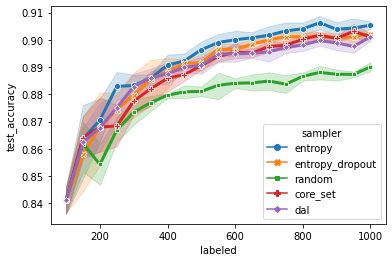

In [60]:
g = sns.lineplot(
    data=df_tr[df_tr.index.get_level_values("mode") == "ada-besov"],
    x="labeled",
    y="test_accuracy",
    hue="sampler",
    style="sampler",
    markers=True,
    dashes=False,
    ci=90,
    linewidth=3,
)
# plt.legend(loc='lower right')
# g.set_ylim(0.8, 0.98)
# g.set_xlim(150, 500)
# g.set_xlim(200, 1000)

In [140]:
datasets = ["MRPC", "TREC-2", "SUBJ", "AGN-2", "TREC-6", "AGN-4", "SST"]
load_anti = False
n = 0  # AL step at which evaluation (AUC) starts
model = "BERT"
mode = "ada"
dataset = "TREC-6"

aucs = []
trs = []
try:
    experiments = load_dataset_results(
        base_dir=f"results/TREC-6",
        dataset=dataset,
        model=model,
    )
except e:
#     print(e)
    print(f"No experiments for {dataset}-{model}-{mode}")
    
for (exp, meta) in experiments:
    for load_mode in ["last", "best"]:
        df_tr_i = experiment_to_df(exp, mode=load_mode)

        df_tr_i["model"] = meta["model"]
        df_tr_i["mode"] = load_mode
        df_tr_i["dataset"] = dataset
        df_tr_i["tapta"] = meta["tapta"]
        df_tr_i["sampler"] = meta["sampler"]
        df_tr_i["adapter"] = meta["adapter"]
        df_tr_i = df_tr_i.reset_index().set_index(
            ["dataset", "model", "adapter", "tapta", "mode", "sampler", "experiment", "al_iter"]
        )
        trs.append(df_tr_i)

        df_auc_i = al_auc(df_tr_i)
        df_auc_i["mode"] = load_mode
        df_auc_i = df_auc_i.reset_index().set_index(["mode", "sampler"])
        aucs.append(df_auc_i)


df_tr = pd.concat(trs)
df_auc = pd.concat(aucs)

TREC-6-BERT


NameError: name 'e' is not defined

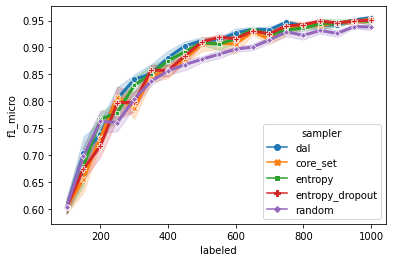

In [44]:
f1 = df_tr.index.get_level_values("mode") == "best"
f2 = df_tr.index.get_level_values("tapta") == True
f3 = df_tr.index.get_level_values("adapter") == "houlsby"

g = sns.lineplot(
    data=df_tr[f1 & f2 & f3],
    x="labeled",
    y="f1_micro",
    hue="sampler",
    style="sampler",
    markers=True,
    dashes=False,
    ci=80,
    linewidth=3,
)
# plt.legend(loc='lower right')
# g.set_ylim(0.8, 0.98)
# g.set_xlim(150, 500)
# g.set_xlim(200, 1000)

In [262]:
f1 = grouped.index.get_level_values("mode") == "best"
f2 = grouped.index.get_level_values("tapta") == tapta
f3 = grouped.index.get_level_values("adapter") == adapter
grouped[f1 & f2 & f3]

labeled  \
dataset model adapter tapta sampler         experiment mode                                                      
SUBJ    BERT  fft     True  core_set        0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            1          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            2          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            3          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            4          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                            dal             0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            1          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            2          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            3          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            4          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                            entropy         0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            1          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            2          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            3          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            4          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                            entropy_dropout 0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            1          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            2          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            3          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            4          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                            random          0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            1          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            2          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            3          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                            4          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   

                                                                                                    train_loss  \
dataset model adapter tapta sampler         experiment mode                                                      
SUBJ    BERT  fft     True  core_set        0          best  [0.008342871675267816, 0.05963614508509636, 0....   
                                            1          best  [0.016990084433928132, 0.1089852437376976, 0.0...   
                                            2          best  [0.29850684106349945, 0.38901899456977845, 0.2...   
                                            3          best  [0.02453012252226472, 0.19331388175487518, 0.1...   
                                            4          best  [0.004845239920541644, 0.09580715149641036, 0....   
                            dal             0          best  [0.008342871675267816, 0.009339978359639645, 0...   
                                            1          best  [0.016990084433928132, 0.032276999577879904, 0...  

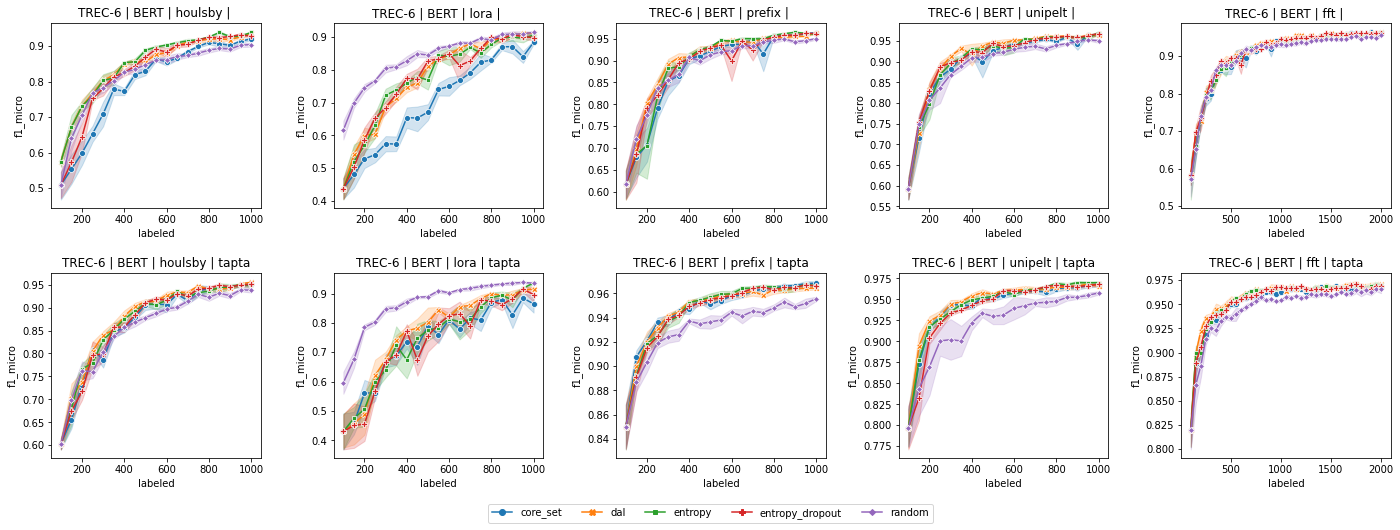

In [139]:
from itertools import product

metric = "f1_micro"
ci = 75

adapters = ["houlsby", "lora", "prefix", "unipelt", "fft"]
taptas = [False, True]
fig, axes = plt.subplots(2, 5, figsize=(24, 8))
axes = axes.ravel()
plt.subplots_adjust(hspace=0.35, wspace=0.35)

for i, (tapta, adapter) in enumerate(product(taptas, adapters)):
    f1 = df_tr.index.get_level_values("mode") == "best"
    f2 = df_tr.index.get_level_values("tapta") == tapta
    f3 = df_tr.index.get_level_values("adapter") == adapter
    g = sns.lineplot(
        ax=axes[i],
        data=df_tr[f1 & f2 & f3].sort_values("sampler"),
        x="labeled",
        y=metric,
        hue="sampler",
        style="sampler",
        markers=True,
        dashes=False,
        ci=ci,
    )
    g.set_title(f"{dataset} | {model} | {adapter} | {'tapta' if tapta else ''}")
    axes[i].get_legend().remove()
    if i == len(axes) - 1:
        handles, labels = axes[i].get_legend_handles_labels()
        g.legend(handles, labels)
        g.legend(loc="center", bbox_to_anchor=(-2.25, -0.3), ncol=5)
        
    

In [ ]:
from itertools import product

metric = "f1_macro"
ci = 75

adapters = ["houlsby", "lora", "prefix", "unipelt", "fft"]
taptas = [False, True]
fig, axes = plt.subplots(2, 5, figsize=(24, 8))
axes = axes.ravel()
plt.subplots_adjust(hspace=0.35, wspace=0.35)

for i, (tapta, adapter) in enumerate(product(taptas, adapters)):
    f1 = df_tr.index.get_level_values("mode") == "best"
    f2 = df_tr.index.get_level_values("tapta") == tapta
    f3 = df_tr.index.get_level_values("adapter") == adapter
    f4 = df_tr.index.get_level_values("experiment") == 0
    filt = df_tr[f1 & f2 & f3 & f4].sort_values("sampler"),
    g = sns.lineplot(
        ax=axes[i],
        data=df_tr[f1 & f2 & f3 & f4].sort_values("sampler"),
        x="labeled",
        y=metric,
        hue="sampler",
        style="sampler",
        markers=True,
        dashes=False,
        ci=ci,
    )
    g.set_title(f"{dataset} | {model} | {adapter} | {'tapta' if tapta else ''}")
    axes[i].get_legend().remove()
    if i == len(axes) - 1:
        handles, labels = axes[i].get_legend_handles_labels()
        g.legend(handles, labels)
        g.legend(loc="center", bbox_to_anchor=(-2.25, -0.3), ncol=5)

In [123]:
df = pd.read_csv("stats/BERT-TREC-6-unipelt.csv", index_col=0)
df_text = pd.read_csv("data/TREC-6/train.csv", header=None, index_col=0)
df["text"] = df_text[1].tolist()
df["label"] = df_text[2].tolist()

In [278]:
df_i.index.names

FrozenList(['dataset', 'model', 'adapter', 'tapta', 'sampler', 'experiment', 'mode'])

In [ ]:
exp_df = pd.DataFrame(columns=list(df_i.index.names).append("forget"))

In [124]:
grouped = df_tr.groupby(["dataset", "model", "adapter", "tapta", "sampler", "experiment", "mode"]).agg(list)
grouped["indices"] = grouped.selected.apply(lambda x: np.concatenate(x[1:]))

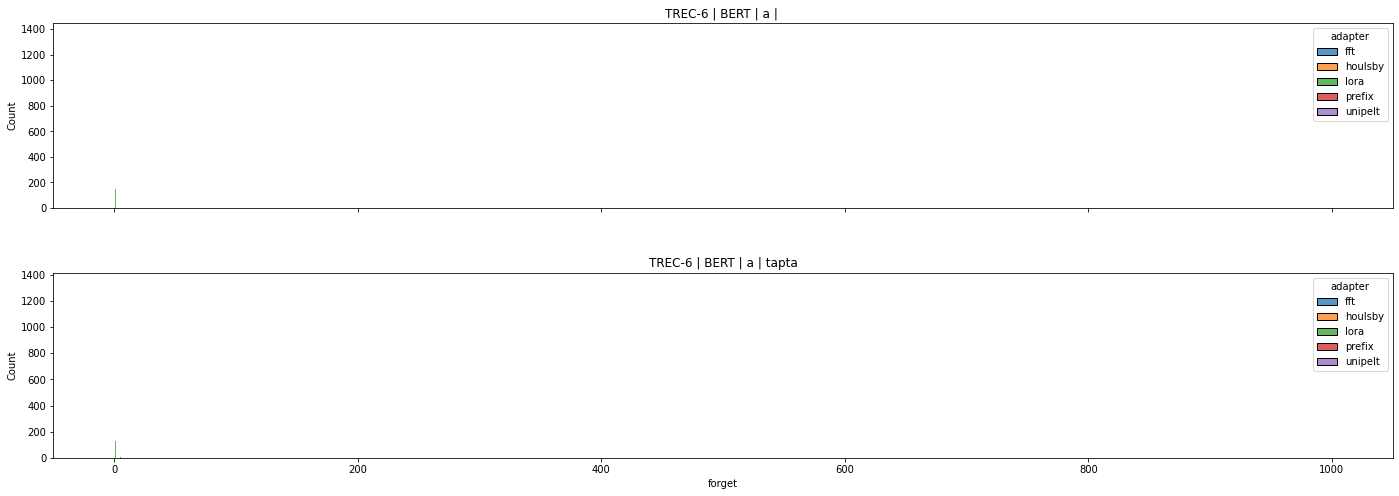

In [125]:
from itertools import product

metric = "f1_micro"
ci = 75

adapters = ["houlsby", "lora", "prefix", "unipelt", "fft"]
taptas = [False, True]
fig, axes = plt.subplots(2, 1, figsize=(24, 8), sharex=True)
axes = axes.ravel()
plt.subplots_adjust(hspace=0.35, wspace=0.35)

for i, (tapta, adapter) in enumerate(product(taptas, ["a"])):
    f1 = grouped.index.get_level_values("mode") == "best"
    f2 = grouped.index.get_level_values("tapta") == tapta
    f3 = grouped.index.get_level_values("sampler") == "entropy_dropout"
    f4 = grouped.index.get_level_values("experiment") == 0
    df_i = grouped[f1 & f2 & f3 & f4].sort_values("sampler")
    forgets = []
    for index, (j, row) in enumerate(df_i.iterrows()):
        df_mini = df.iloc[row.indices]
        forget = df_mini.forgetfulness
        forgets.append(forget.tolist())
    df_i["forget"] = forgets

    g = sns.histplot(
        ax=axes[i],
        data=df_i.explode("forget"),
        x="forget",
        hue="adapter",
        multiple="dodge"
        
    )
    g.set_title(f"{dataset} | {model} | {adapter} | {'tapta' if tapta else ''}")
#     axes[i].get_legend().remove()
#     if i == len(axes) - 1:
#         handles, labels = axes[i].get_legend_handles_labels()
#         g.legend(handles, labels)
#         g.legend(loc="center", bbox_to_anchor=(-2.25, -0.3), ncol=5)
        


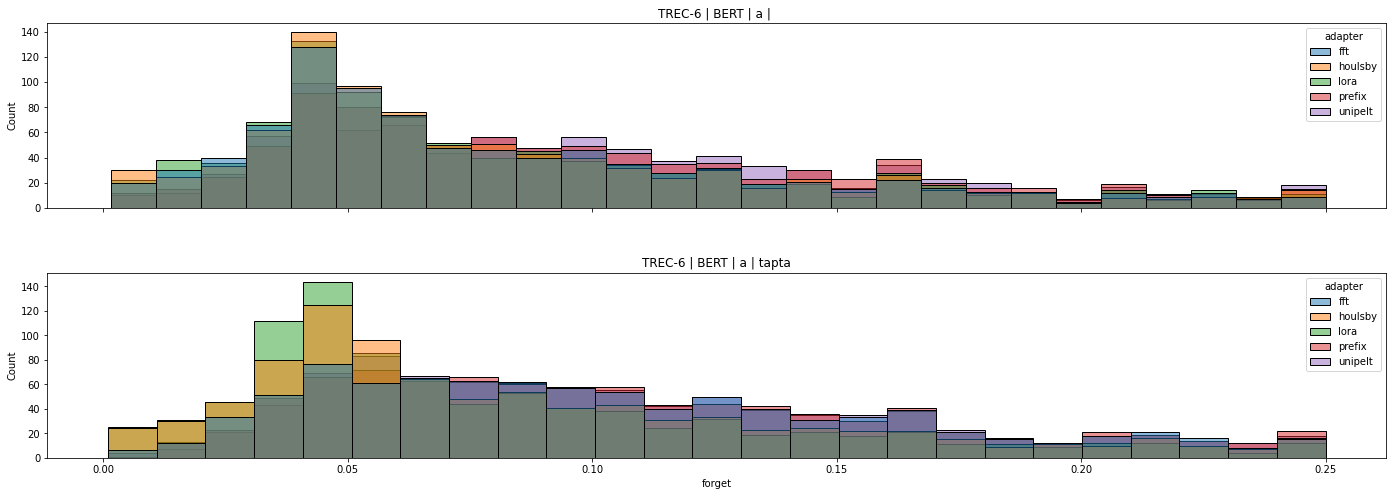

In [137]:
from itertools import product

metric = "f1_micro"
ci = 75

adapters = ["houlsby", "lora", "prefix", "unipelt", "fft"]
taptas = [False, True]
fig, axes = plt.subplots(2, 1, figsize=(24, 8), sharex=True)
axes = axes.ravel()
plt.subplots_adjust(hspace=0.35, wspace=0.35)

for i, (tapta, adapter) in enumerate(product(taptas, ["a"])):
    f1 = grouped.index.get_level_values("mode") == "best"
    f2 = grouped.index.get_level_values("tapta") == tapta
    f3 = grouped.index.get_level_values("sampler") == "entropy_dropout"
    f4 = grouped.index.get_level_values("experiment") == 0
    df_i = grouped[f1 & f2 & f3 & f4].sort_values("sampler")
    forgets = []
    for index, (j, row) in enumerate(df_i.iterrows()):
        df_mini = df.iloc[row.indices[:900]]
        forget = df_mini.threshold_closeness
        forget = forget.replace(1000, 5)
        forgets.append(forget.tolist())
    df_i["forget"] = forgets

    g = sns.histplot(
        ax=axes[i],
        data=df_i.explode("forget"),
        x="forget",
        hue="adapter",
        multiple="layer"
        
    )
    g.set_title(f"{dataset} | {model} | {adapter} | {'tapta' if tapta else ''}")
#     axes[i].get_legend().remove()
#     if i == len(axes) - 1:
#         handles, labels = axes[i].get_legend_handles_labels()
#         g.legend(handles, labels)
#         g.legend(loc="center", bbox_to_anchor=(-2.25, -0.3), ncol=5)
        


In [130]:
df.forgetfulness.value_counts()

0       4213
1        440
2        158
3         48
4         13
5          5
1000       4
Name: forgetfulness, dtype: int64

In [119]:
df_i

labeled  \
dataset model adapter tapta sampler         experiment mode                                                      
SUBJ    BERT  fft     True  entropy_dropout 0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
              houlsby True  entropy_dropout 0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
              lora    True  entropy_dropout 0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
              prefix  True  entropy_dropout 0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
              unipelt True  entropy_dropout 0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   

                                                                                                    train_loss  \
dataset model adapter tapta sampler         experiment mode                                                      
SUBJ    BERT  fft     True  entropy_dropout 0          best  [0.008342871675267816, 0.21090631783008576, 0....   
              houlsby True  entropy_dropout 0          best  [0.0729952473193407, 0.010588760487735271, 0.0...   
              lora    True  entropy_dropout 0          best  [0.014334141509607434, 0.04033788219094277, 0....   
              prefix  True  entropy_dropout 0          best  [0.005088131059892476, 0.03200717222644016, 0....   
              unipelt True  entropy_dropout 0          best  [0.00040586166869616136, 0.00877703633159399, ...   

                                                                                                 test_accuracy  \
dataset model adapter tapta sampler         experiment mode                                                      
SUBJ    BERT  fft     True  entropy_dropout 0          best  [0.9415, 0.95, 0.9495, 0.949, 0.9495, 0.954, 0...   
              houlsby True  entropy_dropout 0          best  [0.9265, 0.9395, 0.9435, 0.946, 0.943, 0.9455,...   
              lora    True  entropy_dropout 0          best  [0.922, 0.9275, 0.9345, 0.945, 0.938, 0.9415, ...   
              prefix  True  entropy_dropout 0          best  [0.926, 0.939, 0.9465, 0.9475, 0.9485, 0.9465,...   
              unipelt True  entropy_dropout 0          best  [0.921, 0.945, 0.943, 0.9435, 0.9485, 0.9405, ...   

                                                                                                      f1_micro  \
dataset model adapter tapta sampler         experiment mode                                                      
SUBJ    BERT  fft     True  entropy_dropout 0          best  [0.9415, 0.9500000000000001, 0.9495, 0.949, 0....   
              houlsby True  entropy_dropout 0          best  [0.9265, 0.9395, 0.9435, 0.946, 0.943, 0.9455,...   
              lora    True  entropy_dropout 0          best  [0.922, 0.9275, 0.9345, 0.945, 0.938, 0.9415, ...   
              prefix  True  entropy_dropout 0          best  [0.926, 0.939, 0.9465, 0.9475, 0.9485, 0.9465,...   
              unipelt True  entropy_dropout 0          best  [0.9209999999999999, 0.945, 0.943, 0.9435, 0.9...   

                                                                                                      f1_macro  \
dataset model adapter tapta sampler         experiment mode                                                      
SUBJ    BERT  fft     True  entropy_dropout 0          best  [0.94148769778846, 0.9499819434815968, 0.94949...   
              houlsby True  entropy_dropout 0          best  [0.926486602183248, 0.9394542122480125, 0.9434...   
              lora    True  entropy_dropout 0          best  [0.9219297367630868, 0.9274451303798498, 0.934...   
              prefix  True  entropy_dropout 0          best  [0.9259854931566587, 0.9389950585997466, 0.946...   
              unipelt True  entropy_dropout 0          best  [0.9209949436763953, 0.9449162175669192, 0.942...   

                                                                                                      select

In [115]:
df

,correctness,confidence,variability,forgetfulness,threshold_closeness,pvi,text,label
0,19,0.971656,0.116787,0,0.027540,0.986856,"de oliveira creates an emotionally rich , poet...",subjective
1,20,0.971997,0.109288,0,0.027219,1.013242,six of the nations brightest spoken word artis...,objective
2,19,0.967204,0.117634,0,0.031720,0.986862,one of those movies that catches you up in som...,subjective
3,17,0.863309,0.268679,2,0.118007,1.013234,showing this beautiful city as seen through th...,objective
4,19,0.972924,0.114635,0,0.026343,1.013248,"based on a true story , the blue butterfly tel...",objective
...,...,...,...,...,...,...,...,...
6995,20,0.999089,0.002673,0,0.000910,0.986859,all very stylish and beautifully photographed ...,subjective
6996,13,0.707101,0.367071,0,0.207109,1.012866,lars von trier re-explores the concept of good...,objective
6997,20,0.999243,0.002065,0,0.000757,1.013248,the game's mastermind has stolen his identity ...,objective
6998,20,0.996929,0.008426,0,0.003061,1.013218,but all efforts are suddenly frustrated once a...,objective


In [ ]:
plt.show()

In [19]:
from models import *
from args import *
from dataloaders import *

args = Config()
args.lr = 2e-5
args.l2 = 0
args.model = "BERT"
args.data = "SUBJ"
# args.adapter = "unipelt"
args.batch_size = 32
args.epochs = 10
args.clip = 1

meta = Config()

dataloader = dataset_loaders[args.data]
tokenizer = AutoTokenizer.from_pretrained(TRANSFORMERS[args.model])
(train, val, test) = dataloader(meta=meta, tokenizer=tokenizer)

if args.data in pair_sequence_datasets:
    meta.pair_sequence = True
else:
    meta.pair_sequence = False
    
meta.task_type = "clf"

if meta.num_labels == 2:
    # Binary classification
    criterion = nn.BCEWithLogitsLoss()
    meta.num_targets = 1
else:
    # Multiclass classification
    criterion = nn.CrossEntropyLoss()
    meta.num_targets = meta.num_labels
    
model = Transformer(args, meta, args.model, pretrained=None, adapter=None)
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.l2)
device = torch.device("cuda:1")



model.to(device)
train_iter = make_iterable(
    train,
    device,
    batch_size=args.batch_size,
    shuffle=True,
#     indices=indices
)

In [11]:
test_iter = make_iterable(
    test,
    device,
    batch_size=args.batch_size,
)

In [17]:
from util import logits_to_probs
from sklearn.metrics import f1_score

In [9]:
import time
from al.experiment import Experiment


def train_model(model, optimizer, criterion, train_iter):
    model.train()

    total_loss = 0.0
    accuracy, confusion_matrix = 0, np.zeros(
        (meta.num_labels, meta.num_labels), dtype=int
    )

    logit_list = []
    y_true_list = []
    ids = []
    for batch_num, batch in enumerate(train_iter, 1):
        t = time.time()

        optimizer.zero_grad()

        ids.extend([id for id in batch.id])

        # Unpack batch & cast to device
        if meta.pair_sequence:
            (x_sequence1, sequence1_lengths) = batch.sequence1
            (x_sequence2, sequence2_lengths) = batch.sequence2
        else:
            x = batch.text

        y = batch.label
        y_true_list.append(y.squeeze(0) if y.numel() == 1 else y.squeeze())

        if meta.pair_sequence:
            # PSQ
            lengths = (sequence1_lengths, sequence2_lengths)
            output, return_dict = model(x_sequence1, x_sequence2, lengths)
            logits = output.logits
        else:
            # SSQ
            output, return_dict = model(x)
            logits = output.logits
        logit_list.append(logits)

        # Bookkeeping and cast label to float
        accuracy, confusion_matrix = Experiment.update_stats(
            accuracy, confusion_matrix, logits, y
        )
        if logits.shape[-1] == 1:
            # binary cross entropy, cast labels to float
            y = y.type(torch.float)

        loss = criterion(logits.view(-1, meta.num_targets).squeeze(), y.squeeze())

        total_loss += float(loss)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()

        print(
            "[Batch]: {}/{} in {:.5f} seconds".format(
                batch_num, len(train_iter), time.time() - t
            ),
            end="\r",
            flush=True,
        )

    loss = total_loss / len(train_iter)
    result_dict = {"loss": loss}
    logit_tensor = torch.cat(logit_list)
    y_true = torch.cat(y_true_list)
    return result_dict, logit_tensor, y_true, ids

def evaluate_model(model, tokenizer, data):
        model.eval()

        accuracy, confusion_matrix = 0, np.zeros(
            (6, 6), dtype=int
        )

        logit_list = []
        y_true_list = []
        with torch.inference_mode():
            for batch_num, batch in enumerate(data):

                t = time.time()

                # Unpack batch & cast to device
                x = batch.text

                y = batch.label
                y = y.squeeze()  # y needs to be a 1D tensor for xent(batch_size)

                y_true_list.append(y.cpu())

                output, _ = model(
                    x,
                )
                loss, logits = output.loss, output.logits

                logit_list.append(logits.cpu())

                # Bookkeeping and cast label to float
                accuracy, confusion_matrix = Experiment.update_stats(
                    accuracy, confusion_matrix, logits, y
                )

                print(
                    "[Batch]: {}/{} in {:.5f} seconds".format(
                        batch_num, len(data), time.time() - t
                    ),
                    end="\r",
                    flush=True,
                )

        logit_tensor = torch.cat(logit_list)
        y_true = torch.cat(y_true_list)
        probs = logits_to_probs(logit_tensor)
        y_pred = torch.argmax(probs, dim=1).numpy()
        f1_micro = f1_score(y_true=y_true, y_pred=y_pred, average="micro")
        f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average="macro")

        print(
            "[Accuracy]: {}/{} : {:.3f}%".format(
                accuracy,
                len(test),
                accuracy / len(test) * 100,
            )
        )
        print(f"[F1-micro]: {f1_micro:.3f}")
        print(f"[F1-macro]: {f1_macro:.3f}")
        print(confusion_matrix)

        result_dict = {
            "accuracy": accuracy / len(test),
            "f1_micro": f1_micro,
            "f1_macro": f1_macro,
        }

        return result_dict, probs, y_true

In [58]:
df_tr.iloc[0].selected.size

100

In [15]:
from util import *

In [20]:
train_results = []
for epoch in range(1, args.epochs + 1):
    print(f"Training epoch: {epoch}/{args.epochs}")
    # a) Train for one epoch
    result_dict_train, logits, y_true, ids = train_model(
        model, optimizer, criterion, train_iter
    )
    print(result_dict_train)
    eval_result_dict = evaluate_model(model=model, tokenizer=tokenizer, data=test_iter)
    print(eval_result_dict)
    train_results.append(result_dict_train)

    # b) Evaluate model (test set)
#     eval_result_dict = self._evaluate_model(model)
#     acc.append(eval_result_dict["accuracy"])
#     loss.append(result_dict_train["loss"])
#     eval_results.append(eval_result_dict)

Training epoch: 1/10
{'loss': 0.30776935764779784}econds
[Accuracy]: 441/2000 : 22.050%nds
[F1-micro]: 0.950
[F1-macro]: 0.950
[[210   9   0   0   0   0]
 [ 14 231   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]]
({'accuracy': 0.2205, 'f1_micro': 0.9504310344827587, 'f1_macro': 0.9503292918479905}, tensor([[0.9829, 0.0171],
        [0.9803, 0.0197],
        [0.9663, 0.0337],
        [0.9806, 0.0194],
        [0.9848, 0.0152],
        [0.9855, 0.0145],
        [0.0101, 0.9899],
        [0.9863, 0.0137],
        [0.0109, 0.9891],
        [0.9362, 0.0638],
        [0.0107, 0.9893],
        [0.9875, 0.0125],
        [0.9844, 0.0156],
        [0.9830, 0.0170],
        [0.8707, 0.1293],
        [0.9709, 0.0291],
        [0.0937, 0.9063],
        [0.0101, 0.9899],
        [0.0101, 0.9899],
        [0.0111, 0.9889],
        [0.1298, 0.8702],
        [0.0120, 0.9880],
        [0.9846, 0.0154],
        [0.9636, 0.0364],

{'loss': 0.1265529644883931}seconds
[Accuracy]: 1920/2000 : 96.000%ds
[F1-micro]: 0.960
[F1-macro]: 0.960
[[938  32   0   0   0   0]
 [ 48 982   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]]
({'accuracy': 0.96, 'f1_micro': 0.96, 'f1_macro': 0.9599806306252225}, tensor([[0.0044, 0.9956],
        [0.9927, 0.0073],
        [0.0042, 0.9958],
        ...,
        [0.9941, 0.0059],
        [0.9935, 0.0065],
        [0.9927, 0.0073]]), tensor([1, 0, 1,  ..., 0, 0, 0]))
Training epoch: 3/10
{'loss': 0.0747633688640887}seconds
[Accuracy]: 1884/2000 : 94.200%ds
[F1-micro]: 0.942
[F1-macro]: 0.942
[[958  12   0   0   0   0]
 [104 926   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]]
({'accuracy': 0.942, 'f1_micro': 0.942, 'f1_macro': 0.9419851481979387}, tensor([[0.0158, 0.9842],
        [0.9982, 0.0018],
        [0.0395, 0.9605],
        ...,
 

In [270]:
eval_result_dict = evaluate_model(model=model, tokenizer=tokenizer, data=test_iter)
print(eval_result_dict)

[Accuracy]: 443/500 : 88.600%onds
[F1-micro]: 0.886
[F1-macro]: 0.856
[[ 79   2  10   2   1   0]
 [  8  50   5   1   1   0]
 [  8   0 120   0   4   6]
 [  2   1   2  76   0   0]
 [  0   0   2   1 110   0]
 [  0   0   1   0   0   8]]
{'accuracy': 0.886, 'f1_micro': 0.886, 'f1_macro': 0.856407058879674}


In [13]:


print(num_layers)

12


In [14]:
df = df_tr[
    (df_tr.index.get_level_values("sampler") == "entropy")
    & (df_tr.index.get_level_values("mode") == "ada-besov")
    & (df_tr.index.get_level_values("experiment") == 0)
]

In [15]:
selected = df.selected.agg(list)

In [16]:
sel = [s for ss in selected for s in ss]

In [17]:
indices = np.array(sel)

In [194]:
len(indices)

755

In [26]:
model.eval()
name = model.get_classifier_name()
clf = model.classifier
config = model.classifier.config
num_layers = config.num_hidden_layers

enc = []
grads = []
labels = []
enc_layers = {i: [] for i in range(num_layers)}


train_iter = make_iterable(
    train,
    device,
    batch_size=args.batch_size,
    shuffle=False,
)


with torch.inference_mode():
    for batch in train_iter:

        print(batch)
        inputs = batch.text
        labels.append(batch.label)
        inputs.requires_grad = False

    #     embedded_tokens = clf.bert.embeddings(inputs)
    #     embedded_tokens = torch.autograd.Variable(
    #         embedded_tokens, requires_grad=True
    #     )
        encoded_all = clf(
            inputs,
            output_hidden_states=True,
            # head_mask=head_mask,
            # attention_mask=attention_mask,
        )
        # Skip the embedding layer [1:]
        for i, enc_layer in enumerate(encoded_all[1][1:]):
            enc_layers[i].append(enc_layer[:, 0].cpu())


        encoded = encoded_all[0][:, 0]
        enc.append(encoded.cpu())

        torch.cuda.empty_cache()

    y = torch.cat(labels)
    for k, v in enc_layers.items():
        X = torch.cat(v)
        enc_layers[k] = X

Batch({
    id: [8170, 3821, 9675, 1186, 361, 451, 6559, 1461, 7907, 513, 5178, 1927, 8537, 6715, 3898, 7261, 3198, 8881, 1641, 1811, 3238, 1764, 3737, 5747, 892, 3682, 111, 7948, 5959, 6847, 6819, 9936],
    text: tensor([[ 2139, 24263,  9005,  ...,     0,     0,     0],
            [ 2416,  1997,  1996,  ...,     0,     0,     0],
            [ 2028,  1997,  2216,  ...,     0,     0,     0],
            ...,
            [ 3422,  2004,  1996,  ...,     0,     0,     0],
            [ 1037,  4086,  1010,  ...,     0,     0,     0],
            [ 2054,  2428,  3084,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[0],
            [1],
            [0],
            [1],
            [1],
            [1],
            [0],
            [1],
            [0],
            [0],
            [0],
            [0],
            [1],
            [1],
            [0],
            [1],
            [1],
            [0],
            [0],
            [1],
            [0],
            [1],


Batch({
    id: [5052, 7228, 610, 4747, 3235, 8984, 1832, 249, 8044, 7361, 2026, 784, 5805, 5736, 8310, 8680, 5327, 9265, 9934, 9812, 7629, 2199, 5795, 4178, 1242, 9681, 2447, 1670, 854, 4455, 8750, 2382],
    text: tensor([[ 2242, 17793,  2000,  ...,     0,     0,     0],
            [14262,  2854,  6669,  ...,     0,     0,     0],
            [ 1037,  2143,  2005,  ...,     0,     0,     0],
            ...,
            [ 1012,  1012,  1012,  ...,     0,     0,     0],
            [ 2085,  1010,  1999,  ...,  2035,  4763,  1012],
            [ 1037,  2569,  2785,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[0],
            [0],
            [0],
            [1],
            [1],
            [1],
            [0],
            [0],
            [1],
            [1],
            [0],
            [0],
            [0],
            [0],
            [1],
            [1],
            [1],
            [1],
            [0],
            [1],
            [1],
            [1],

Batch({
    id: [5937, 3208, 2998, 7135, 1209, 2965, 1456, 3866, 2735, 4690, 2505, 3974, 4875, 5287, 7046, 2811, 2710, 8482, 5988, 1752, 6603, 1372, 1691, 3799, 6868, 5260, 7796, 4780, 3299, 8719, 1320, 3480],
    text: tensor([[ 2348, 13362, 22231,  ...,     0,     0,     0],
            [ 2023,  2003,  1037,  ...,     0,     0,     0],
            [16686, 28173,  1005,  ...,     0,     0,     0],
            ...,
            [ 2045,  1005,  1055,  ...,     0,     0,     0],
            [ 1998,  2071,  2183,  ...,     0,     0,     0],
            [21566,  2155,  1999,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[0],
            [0],
            [0],
            [1],
            [1],
            [0],
            [1],
            [1],
            [0],
            [0],
            [1],
            [1],
            [1],
            [1],
            [1],
            [0],
            [1],
            [0],
            [1],
            [0],
            [0],
            

Batch({
    id: [4705, 2628, 4663, 8512, 4936, 804, 2440, 5282, 3078, 3899, 1737, 8340, 2852, 1991, 8819, 5057, 8820, 1728, 5546, 4756, 9384, 7193, 7566, 9626, 9968, 6732, 2886, 3398, 6892, 5409, 2853, 2437],
    text: tensor([[ 1999,  1996,  5192,  ...,     0,     0,     0],
            [ 2076,  6265,  1010,  ...,     0,     0,     0],
            [11648,  2003,  1037,  ...,     0,     0,     0],
            ...,
            [ 3262,  2573,  2138,  ...,     0,     0,     0],
            [ 2011,  4332,  3653,  ...,     0,     0,     0],
            [16036,  2000,  2191,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[1],
            [1],
            [1],
            [0],
            [0],
            [0],
            [1],
            [0],
            [1],
            [1],
            [0],
            [1],
            [0],
            [1],
            [0],
            [1],
            [1],
            [1],
            [0],
            [0],
            [1],
            [

Batch({
    id: [3441, 11, 7550, 3250, 5312, 9190, 5946, 1084, 1559, 6098, 3588, 7890, 6396, 9673, 8080, 2314, 4, 6377, 9560, 7280, 1601, 4981, 6725, 5208, 4655, 3266, 1921, 8508, 6575, 8346, 9218, 350],
    text: tensor([[ 1037,  2969,  1011,  ...,     0,     0,     0],
            [ 7591,  7241,  4616,  ...,     0,     0,     0],
            [ 1037,  6474,  2086,  ...,     0,     0,     0],
            ...,
            [ 1996,  5889,  2024,  ...,     0,     0,     0],
            [ 2061,  2023,  2679,  ...,     0,     0,     0],
            [ 2023, 27243, 20067,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[0],
            [0],
            [1],
            [1],
            [0],
            [0],
            [0],
            [1],
            [1],
            [0],
            [0],
            [0],
            [0],
            [1],
            [1],
            [1],
            [1],
            [0],
            [1],
            [1],
            [1],
            [0],
 

Batch({
    id: [4596, 7919, 1507, 7841, 1847, 4468, 2406, 3118, 7291, 3571, 3217, 2471, 4564, 4587, 1189, 2624, 9709, 9889, 96, 6087, 6560, 5814, 7428, 8597, 7839, 4263, 5640, 5167, 8565, 3925, 7775, 3545],
    text: tensor([[ 2065, 17738,  2003,  ...,     0,     0,     0],
            [ 1996,  2406,  6468,  ...,     0,     0,     0],
            [11902, 29587,  1010,  ...,     0,     0,     0],
            ...,
            [10514,  2243,  1010,  ...,     0,     0,     0],
            [ 4448,  2103, 14419,  ...,     0,     0,     0],
            [ 1999,  1996,  9807,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[0],
            [0],
            [1],
            [0],
            [0],
            [0],
            [1],
            [0],
            [0],
            [0],
            [1],
            [1],
            [1],
            [1],
            [1],
            [1],
            [1],
            [1],
            [0],
            [1],
            [1],
            [1

Batch({
    id: [826, 9345, 7521, 3797, 5382, 7282, 6622, 1171, 2942, 6785, 8505, 3683, 210, 546, 4424, 8665, 7491, 831, 1759, 3801, 837, 4888, 3074, 5618, 1355, 4261, 2016, 9985, 6698, 7424, 9760, 2707],
    text: tensor([[ 2054, 13695,  1996,  ...,     0,     0,     0],
            [ 2027,  1005,  2128,  ...,     0,     0,     0],
            [ 2023,  2001,  2036,  ...,     0,     0,     0],
            ...,
            [ 5921,  2122,  1010,  ...,     0,     0,     0],
            [ 6766,  7266,  2039,  ...,     0,     0,     0],
            [ 2004,  2027,  2147,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[0],
            [1],
            [1],
            [1],
            [0],
            [1],
            [0],
            [0],
            [0],
            [0],
            [1],
            [0],
            [1],
            [0],
            [1],
            [1],
            [1],
            [0],
            [0],
            [0],
            [1],
            [0],


Batch({
    id: [1221, 3221, 1361, 4339, 6208, 4266, 6475, 5129, 6994, 7852, 8687, 9820, 5512, 1981, 824, 1762, 6266, 5541, 2659, 336, 9767, 4463, 1987, 6798, 4073, 9231, 1724, 4950, 2147, 1997, 2866, 2099],
    text: tensor([[ 2062,  3144,  2012,  ...,     0,     0,     0],
            [13059,  7054,  7782,  ...,     0,     0,     0],
            [ 1999,  2014,  6724,  ...,  2354,  2009,  1012],
            ...,
            [ 5621,  2019,  7789,  ...,     0,     0,     0],
            [21805,  2038,  2061,  ...,     0,     0,     0],
            [ 1996,  2504,  1997,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[0],
            [0],
            [1],
            [1],
            [1],
            [1],
            [1],
            [1],
            [0],
            [1],
            [0],
            [1],
            [0],
            [1],
            [1],
            [0],
            [1],
            [1],
            [0],
            [1],
            [1],
            [0

Batch({
    id: [4675, 3580, 2860, 2294, 4045, 9348, 8843, 925, 6089, 445, 1863, 4826, 6992, 2825, 2993, 4967, 7339, 3610, 7734, 6805, 4819, 2949, 6869, 4659, 1628, 7612, 9787, 1577, 2120, 2403, 3697, 1300],
    text: tensor([[17595,  9805,  2003,  ...,     0,     0,     0],
            [ 2012,  2023,  2521,  ...,     0,     0,     0],
            [ 1999,  1037,  2197,  ...,     0,     0,     0],
            ...,
            [25626,  8617,  1037,  ...,     0,     0,     0],
            [ 2664,  1010,  4218,  ...,     0,     0,     0],
            [ 2247,  1996,  2126,  ...,  1012,  1012,  1012]], device='cuda:1'),
    label: tensor([[0],
            [1],
            [1],
            [1],
            [0],
            [0],
            [1],
            [1],
            [1],
            [1],
            [1],
            [1],
            [0],
            [1],
            [1],
            [1],
            [1],
            [0],
            [0],
            [0],
            [1],
            [1

Batch({
    id: [6304, 2706, 196, 4326, 3889, 4876, 9007, 1525, 8703, 3638, 8809, 406, 753, 8267, 5544, 8333, 6604, 7303, 7459, 6412, 1191, 747, 2983, 9942, 5603, 6549, 50, 7990, 6339, 7171, 5584, 4908],
    text: tensor([[ 2574,  1010,  4295,  ...,     0,     0,     0],
            [ 3904,  1997,  2122,  ...,     0,     0,     0],
            [ 2014,  2524,  4061,  ...,     0,     0,     0],
            ...,
            [ 1037,  2143,  2302,  ...,     0,     0,     0],
            [ 4445,  2004, 12459,  ...,     0,     0,     0],
            [ 1037,  3809,  3185,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[1],
            [0],
            [1],
            [1],
            [1],
            [0],
            [0],
            [1],
            [0],
            [0],
            [1],
            [0],
            [1],
            [1],
            [1],
            [1],
            [0],
            [1],
            [1],
            [0],
            [0],
            [0],
 

Batch({
    id: [7264, 5152, 8139, 8262, 9196, 6076, 3589, 144, 3196, 5468, 5000, 1336, 7937, 4359, 702, 3379, 1924, 163, 8210, 643, 2723, 7918, 8802, 7706, 7234, 2667, 9278, 4902, 1026, 1478, 4157, 8985],
    text: tensor([[ 2664,  2009,  2001,  ...,     0,     0,     0],
            [ 2009,  1005,  1055,  ...,     0,     0,     0],
            [ 1999,  3054,  1011,  ...,     0,     0,     0],
            ...,
            [ 1037, 25047,  1010,  ...,     0,     0,     0],
            [ 2101,  2006,  1010,  ...,     0,     0,     0],
            [ 2320,  2588,  1037,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[1],
            [0],
            [1],
            [0],
            [0],
            [0],
            [1],
            [0],
            [0],
            [1],
            [0],
            [0],
            [1],
            [1],
            [0],
            [0],
            [0],
            [1],
            [1],
            [1],
            [1],
            [0],

Batch({
    id: [7446, 9923, 5851, 993, 8378, 3828, 8642, 5259, 7687, 21, 5245, 2656, 1285, 335, 8301, 6222, 1743, 2761, 5191, 5085, 8657, 1153, 8944, 3967, 9282, 3083, 6790, 2525, 4853, 1164, 9071, 6001],
    text: tensor([[23581,  1996, 12632,  ...,     0,     0,     0],
            [ 2005,  1037,  2466,  ...,     0,     0,     0],
            [ 1000, 26352,  2015,  ...,  2037,  3268,  1012],
            ...,
            [ 2027,  2035,  5630,  ...,     0,     0,     0],
            [ 2014, 28505,  1010,  ...,     0,     0,     0],
            [ 4066,  1997,  2019,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[1],
            [0],
            [1],
            [1],
            [0],
            [0],
            [1],
            [1],
            [1],
            [1],
            [0],
            [1],
            [1],
            [1],
            [1],
            [1],
            [1],
            [0],
            [0],
            [1],
            [1],
            [0],

Batch({
    id: [2608, 1919, 1092, 1736, 4051, 7649, 1071, 4779, 8488, 8157, 7117, 2341, 1436, 8150, 5972, 9125, 8606, 7809, 6939, 8481, 9996, 607, 5678, 6924, 7777, 5830, 9723, 1501, 8551, 6914, 9213, 9434],
    text: tensor([[ 2028,  2064,  2069,  ...,     0,     0,     0],
            [12280,  2780,  2039,  ...,  5933,  5286,  1012],
            [ 2002,  2038,  2525,  ...,     0,     0,     0],
            ...,
            [ 5834,  2588,  2115,  ...,     0,     0,     0],
            [ 2021,  2043, 25353,  ...,     0,     0,     0],
            [ 5001,  2094,  6317,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[0],
            [1],
            [1],
            [1],
            [1],
            [1],
            [0],
            [1],
            [0],
            [0],
            [1],
            [0],
            [0],
            [1],
            [1],
            [1],
            [0],
            [1],
            [0],
            [0],
            [1],
            [

Batch({
    id: [1746, 1065, 7378, 8436, 8527, 6565, 876, 3893, 4989, 7949, 283, 4096, 9073, 7345, 4790, 3136, 5886, 1018, 5394, 8049, 4408, 1658, 3942, 6013, 9731, 8916, 8153, 2566, 9109, 8525, 5595, 6045],
    text: tensor([[1037, 2308, 2013,  ...,    0,    0,    0],
            [1996, 3185, 2003,  ...,    0,    0,    0],
            [2059, 1996, 2279,  ...,    0,    0,    0],
            ...,
            [2009, 2038, 2062,  ...,    0,    0,    0],
            [1996, 2662, 2078,  ...,    0,    0,    0],
            [3251, 2053, 3286,  ...,    0,    0,    0]], device='cuda:1'),
    label: tensor([[1],
            [0],
            [1],
            [1],
            [1],
            [0],
            [1],
            [0],
            [0],
            [0],
            [0],
            [0],
            [0],
            [1],
            [0],
            [1],
            [0],
            [0],
            [1],
            [0],
            [1],
            [0],
            [1],
            [0],

Batch({
    id: [9062, 519, 461, 2498, 4642, 8256, 7556, 5598, 5237, 7953, 9404, 955, 2066, 7610, 9081, 2356, 5611, 3018, 8274, 1459, 1660, 4972, 3267, 571, 3796, 6100, 3458, 9226, 8914, 4727, 5920, 5744],
    text: tensor([[ 2037,  2166,  1010,  ...,  2166,  9868,  1012],
            [ 1996,  2413,  2024,  ...,     0,     0,     0],
            [ 2010, 10461,  3658,  ...,     0,     0,     0],
            ...,
            [ 2241,  2006,  2019,  ...,     0,     0,     0],
            [ 2043,  2016,  7288,  ...,     0,     0,     0],
            [ 1998,  2065,  2016,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[1],
            [0],
            [1],
            [1],
            [0],
            [0],
            [0],
            [1],
            [1],
            [0],
            [0],
            [1],
            [0],
            [1],
            [0],
            [0],
            [1],
            [0],
            [1],
            [0],
            [0],
            [1],

Batch({
    id: [9340, 1803, 9027, 5010, 9643, 84, 9445, 9531, 693, 4912, 4460, 8950, 126, 9295, 4507, 6636, 2838, 286, 8468, 1325, 7201, 5557, 999, 9694, 8837, 5034, 9, 5677, 8731, 6943, 6846, 8607],
    text: tensor([[ 2017,  2113,  2008,  ...,     0,     0,     0],
            [ 2027,  2468,  1996,  ...,     0,     0,     0],
            [ 2043, 10380, 13663,  ...,     0,     0,     0],
            ...,
            [ 1041,  8529,  2050,  ...,     0,     0,     0],
            [ 2004,  2010,  4005,  ...,     0,     0,     0],
            [ 1996, 12127,  2004,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[0],
            [1],
            [1],
            [0],
            [1],
            [1],
            [0],
            [0],
            [1],
            [1],
            [0],
            [0],
            [0],
            [1],
            [1],
            [0],
            [1],
            [0],
            [1],
            [0],
            [0],
            [1],
    

Batch({
    id: [3315, 3608, 9430, 8727, 6632, 2800, 2324, 8811, 4191, 1650, 4906, 3220, 5881, 6985, 994, 777, 3006, 3724, 4130, 8855, 2049, 7154, 9819, 9075, 4586, 4827, 4962, 7041, 8808, 1798, 9729, 5271],
    text: tensor([[ 5674,  1037,  2143,  ...,     0,     0,     0],
            [ 4268,  2097,  2293,  ...,     0,     0,     0],
            [ 1037,  6397,  2611,  ...,     0,     0,     0],
            ...,
            [16172,  1010,  2006,  ...,     0,     0,     0],
            [15617,  2001,  2785,  ...,     0,     0,     0],
            [ 2061,  2402,  1010,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[0],
            [0],
            [1],
            [0],
            [1],
            [0],
            [0],
            [1],
            [1],
            [0],
            [1],
            [1],
            [1],
            [0],
            [1],
            [1],
            [1],
            [0],
            [1],
            [1],
            [0],
            [1

Batch({
    id: [3548, 8053, 6891, 1, 6505, 4143, 5780, 1963, 6477, 5125, 7374, 186, 3812, 8285, 4071, 6557, 4533, 3216, 555, 5107, 3029, 3669, 5144, 7548, 2428, 9269, 5927, 3086, 7030, 3751, 1444, 167],
    text: tensor([[ 1996,  2437,  1997,  ...,     0,     0,     0],
            [ 2023,  5988,  2310,  ...,     0,     0,     0],
            [ 1996,  2147,  1997,  ...,     0,     0,     0],
            ...,
            [ 2093, 28616, 16179,  ...,     0,     0,     0],
            [ 1037,  2093,  2112,  ...,     0,     0,     0],
            [ 2058,  3770,  1997,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[1],
            [0],
            [0],
            [1],
            [1],
            [1],
            [1],
            [1],
            [0],
            [1],
            [0],
            [1],
            [1],
            [1],
            [0],
            [1],
            [0],
            [0],
            [1],
            [0],
            [1],
            [0],
 

Batch({
    id: [5887, 9660, 97, 5443, 4770, 8729, 8200, 4574, 9978, 3914, 5555, 3679, 4873, 110, 1103, 3322, 8832, 8861, 8725, 3439, 7091, 3649, 7835, 7748, 3743, 3473, 3857, 4502, 8544, 8131, 7903, 3620],
    text: tensor([[ 2006,  1996,  2346,  ...,     0,     0,     0],
            [ 2023,  4627,  2125,  ...,     0,     0,     0],
            [ 2043,  2025, 23649,  ...,     0,     0,     0],
            ...,
            [ 2009,  1005,  1055,  ...,     0,     0,     0],
            [ 1999,  3339,  1010,  ...,     0,     0,     0],
            [ 1031, 17738,  1033,  ...,  4133,  2083,  1012]], device='cuda:1'),
    label: tensor([[1],
            [0],
            [0],
            [1],
            [0],
            [0],
            [1],
            [0],
            [0],
            [0],
            [1],
            [0],
            [1],
            [1],
            [0],
            [1],
            [1],
            [1],
            [0],
            [0],
            [1],
            [0]

Batch({
    id: [9338, 9990, 6139, 3784, 5209, 8519, 4194, 5501, 228, 703, 1490, 3138, 3605, 4992, 5503, 4753, 6046, 3418, 9455, 2587, 5251, 5397, 372, 391, 3499, 6164, 4291, 4591, 3909, 1860, 4555, 255],
    text: tensor([[19566,  2008,  2566,  ...,     0,     0,     0],
            [ 2174,  1010,  8945,  ...,     0,     0,     0],
            [ 1996,  3291,  2003,  ...,     0,     0,     0],
            ...,
            [ 2625,  2055,  8101,  ...,     0,     0,     0],
            [ 1996,  9458,  2442,  ...,     0,     0,     0],
            [ 4678,  2003,  1996,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[0],
            [1],
            [0],
            [0],
            [1],
            [0],
            [1],
            [0],
            [1],
            [0],
            [0],
            [0],
            [0],
            [1],
            [1],
            [0],
            [1],
            [1],
            [0],
            [1],
            [1],
            [0],


Batch({
    id: [7972, 6836, 4662, 4417, 79, 6666, 8542, 9422, 7735, 2585, 68, 5356, 5038, 9225, 9435, 158, 6904, 8545, 9690, 259, 6257, 1154, 294, 7892, 9350, 3164, 5532, 7683, 7367, 2140, 6290, 1715],
    text: tensor([[ 2665,  2453,  2215,  ...,     0,     0,     0],
            [ 2016,  4978,  2014,  ...,     0,     0,     0],
            [ 2076,  1996,  2607,  ...,     0,     0,     0],
            ...,
            [ 1037,  2512,  1011,  ...,     0,     0,     0],
            [ 2011,  4332, 13940,  ...,     0,     0,     0],
            [ 8994,  1006, 11284,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[0],
            [1],
            [1],
            [0],
            [1],
            [0],
            [0],
            [1],
            [1],
            [0],
            [0],
            [0],
            [1],
            [1],
            [0],
            [0],
            [1],
            [0],
            [0],
            [0],
            [1],
            [1],
  

Batch({
    id: [460, 3518, 3070, 540, 1282, 4052, 9094, 2562, 7214, 8297, 4432, 4513, 2271, 5268, 9961, 2551, 935, 20, 5590, 4626, 8269, 7519, 2752, 7208, 774, 2010, 5037, 5888, 5831, 4928, 7484, 3674],
    text: tensor([[ 2009,  1005,  1055,  ...,     0,     0,     0],
            [25283, 26147,  5740,  ...,     0,     0,     0],
            [ 2062, 14036,  2084,  ...,     0,     0,     0],
            ...,
            [ 2034,  1998, 16097,  ...,     0,     0,     0],
            [ 1996, 15774,  2024,  ...,     0,     0,     0],
            [ 2129,  2079,  2017,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[0],
            [1],
            [0],
            [1],
            [0],
            [1],
            [0],
            [1],
            [1],
            [1],
            [1],
            [1],
            [0],
            [1],
            [1],
            [0],
            [0],
            [1],
            [0],
            [1],
            [1],
            [0],
 

Batch({
    id: [7741, 7725, 5006, 8117, 1425, 9482, 298, 8646, 4855, 8337, 4422, 9800, 3452, 5958, 4593, 4575, 5759, 6755, 2385, 8559, 5284, 4391, 6917, 7226, 2928, 4583, 8361, 9586, 3274, 4974, 4082, 1689],
    text: tensor([[ 2009,  3640,  1996,  ...,     0,     0,     0],
            [ 1996,  7214,  3494,  ...,     0,     0,     0],
            [ 2002,  1005,  1055,  ...,  5593,  2767,  1012],
            ...,
            [ 1996,  6827,  3291,  ...,     0,     0,     0],
            [ 1996, 13749, 18595,  ...,     0,     0,     0],
            [ 2021,  2043, 20868,  ...,     0,     0,     0]], device='cuda:1'),
    label: tensor([[0],
            [1],
            [1],
            [0],
            [0],
            [0],
            [1],
            [0],
            [0],
            [1],
            [0],
            [1],
            [1],
            [1],
            [1],
            [1],
            [1],
            [0],
            [0],
            [0],
            [0],
            [

In [29]:
X = enc_layers[11]

In [28]:
enc = []
grads = []
labels = []
enc_layers = {i: [] for i in range(num_layers)}


train_iter = make_iterable(
    train,
    device,
    batch_size=args.batch_size,
    train=False,
    indices=indices,
)

for batch in train_iter:

    print(batch)
    inputs, _ = batch.text
    labels.append(batch.label)
    inputs.requires_grad = False

    embedded_tokens = clf.embeddings(inputs)
    embedded_tokens = torch.autograd.Variable(
        embedded_tokens, requires_grad=True
    )
    encoded_all = clf(
        embedded_tokens,
        output_hidden_states=True,
        # head_mask=head_mask,
        # attention_mask=attention_mask,
    )
    # Skip the embedding layer [1:]
    for i, enc_layer in enumerate(encoded_all[1][1:]):
        enc_layers[i].append(enc_layer[:, 0].cpu())

    encoded = encoded_all[0][:, 0]
    enc.append(encoded.cpu())

    mean = encoded.mean()
    mean.backward()
    enc_grad = embedded_tokens.grad.data
    grads.append(enc_grad.norm(p=2, dim=(1, 2)))

    torch.cuda.empty_cache()

y = torch.cat(labels)
for k, v in enc_layers.items():
    X = torch.cat(v)
    enc_layers[k] = X

Batch({
    id: [['4442'], ['3232'], ['1394'], ['3291'], ['2935'], ['1759'], ['2570'], ['1266'], ['947'], ['3735'], ['3879'], ['1554'], ['1940'], ['2422'], ['3757'], ['442'], ['3294'], ['5008'], ['2737'], ['614'], ['4142'], ['1143'], ['563'], ['4516'], ['4478'], ['726'], ['1453'], ['3919'], ['3888'], ['1416'], ['216'], ['3616']],
    text: (tensor([[ 2040,  6791,  2492,  8610, 22209, 17083, 10199,  1999,  1996,  5532,
              4419,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2073,  2064,  2017,  2424,  1996, 11691,  4875,  6494,  2361,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2054,  2515,  2169,  1997,  1996, 16548,  3465,  1999, 15404,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2339,  2003,  1996,  2773, 22498,  2061,  2146,     0,     0,     0,
                 0,     0,     0,     0,     0,     0,     0,     0,     0],
            [ 2054,  

AttributeError: 'BertAdapterModel' object has no attribute 'embeddings'

In [30]:
enc_layers

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: []}

In [48]:
clf.encoder.forward?

In [ ]:
X_model = enc_layers[-1].detach().numpy()

In [37]:
df

labeled  \
dataset model model sampler         experiment                                                      
SUBJ    BERT  BERT  core_set        0           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                    dal             0           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                    entropy         0           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                    entropy_dropout 0           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                    random          0           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   

                                                                                       train_loss  \
dataset model model sampler         experiment                                                      
SUBJ    BERT  BERT  core_set        0           [0.0017405070830136538, 0.00043193715391680597...   
                    dal             0           [0.00040586166869616136, 0.0023457331291865556...   
                    entropy         0           [0.00043148809345439076, 0.0008264001633506268...   
                    entropy_dropout 0           [0.00040586166869616136, 0.0002729955653194338...   
                    random          0           [0.0008493601635564119, 0.0025898094463627785,...   

                                                                                    test_accuracy  \
dataset model model sampler         experiment                                                      
SUBJ    BERT  BERT  core_set        0           [0.906, 0.907, 0.922, 0.936, 0.9375, 0.927, 0....   
                    dal             0           [0.921, 0.9305, 0.936, 0.9225, 0.9435, 0.9445,...   
                    entropy         0           [0.915, 0.929, 0.9385, 0.9365, 0.9285, 0.9485,...   
                    entropy_dropout 0           [0.921, 0.9395, 0.939, 0.9255, 0.929, 0.9365, ...   
                    random          0           [0.894, 0.92, 0.918, 0.9025, 0.924, 0.9245, 0....   

                                                                                         f1_micro  \
dataset model model sampler         experiment                                                      
SUBJ    BERT  BERT  core_set        0           [0.906, 0.907, 0.922, 0.936, 0.9375, 0.927, 0....   
                    dal             0           [0.9209999999999999, 0.9305, 0.936, 0.9225, 0....   
                    entropy         0           [0.915, 0.929, 0.9385, 0.9365, 0.9285, 0.9485,...   
                    entropy_dropout 0           [0.9209999999999999, 0.9395, 0.939, 0.9255, 0....   
                    random          0           [0.894, 0.92, 0.918, 0.9025, 0.924, 0.9245, 0....   

                                                                                         f1_macro  \
dataset model model sampler         experiment                                                      
SUBJ    BERT  BERT  core_set        0           [0.9059623849539816, 0.9069976749418736, 0.921...   
                    dal             0           [0.9209949436763953, 0.9304991486145706, 0.935...   
                    entropy         0           [0.9149550112009253, 0.928992899289929, 0.9384...   
                    entropy_dropout 0           [0.9209949436763953, 0.9394769861239736, 0.938...   
                    random          0           [0.8934163479212166, 0.9199179960279327, 0.917...   

                                                                                         selected  
dataset model model sampler         experiment                                                     
SUBJ    BERT  BERT  core_set        0           [[2305, 4388, 1686, 4945, 4197, 1651, 1528, 63...  
                    dal             0           [[2305, 4388, 1686, 4945, 4197, 1651, 1528, 63...  
                    entropy         0           [[2305, 4388, 1686, 4945, 4197, 1651, 1528, 63...  
                    entropy_dropout 0           [[

In [43]:
df

labeled  \
dataset model adapter sampler  experiment                                                      
SUBJ    BERT  fft     core_set 0           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                               1           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                               2           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                               3           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                               4           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
...                                                                                      ...   
              unipelt random   0           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                               1           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                               2           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                               3           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                               4           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   

                                                                                  train_loss  \
dataset model adapter sampler  experiment                                                      
SUBJ    BERT  fft     core_set 0           [0.05477863736450672, 0.015543065778911114, 0....   
                               1           [0.08393486868590117, 0.034584060311317444, 0....   
                               2           [0.025904068257659674, 0.009657853282988071, 0...   
                               3           [0.22618058882653713, 0.042612628638744356, 0....   
                               4           [0.012241830118000507, 0.02187708839774132, 0....   
...                                                                                      ...   
              unipelt random   0           [0.00040586166869616136, 0.0001979944558115676...   
                               1           [0.00022194598568603396, 0.001066342042759061,...   
                               2           [0.00028843421023339033, 0.0002357221761485561...   
                               3           [0.00028132412262493744, 0.0003146255854517221...   
                               4           [0.0006057980135665275, 0.00020836981711909176...   

                                                                               test_accuracy  \
dataset model adapter sampler  experiment                                                      
SUBJ    BERT  fft     core_set 0           [0.8895, 0.903, 0.9175, 0.9195, 0.9335, 0.9205...   
                               1           [0.828, 0.91, 0.92, 0.9305, 0.935, 0.919, 0.93...   
                               2           [0.838, 0.9065, 0.8935, 0.867, 0.922, 0.925, 0...   
                               3           [0.776, 0.893, 0.912, 0.9035, 0.884, 0.918, 0....   
                               4           [0.896, 0.9185, 0.9155, 0.8835, 0.9215, 0.9285...   
...                                                                                      ...   
              unipelt random   0           [0.921, 0.926, 0.9355, 0.9315, 0.93, 0.9325, 0...   
                               1           [0.9125, 0.91, 0.938, 0.937, 0.9485, 0.9365, 0...   
                               2           [0.9185, 0.915, 0.927, 0.9235, 0.931, 0.908, 0...   
                               3           [0.9085, 0.923, 0.9205, 0.933, 0.933, 0.941, 0...   
                               4           [0.9035, 0.926, 0.93, 0.9145, 0.9385, 0.942, 0...   

                                                                                    f1_micro  \
dataset model adapter sampler  experiment                                                      
SUBJ    BERT  fft     core_set 0           [0.8895, 0.903, 0.9175, 0.9195, 0.9335, 0.9205...   
                               1           [0.828,

In [65]:
df_tr

labeled  \
dataset model adapter tapta mode sampler         experiment al_iter            
SUBJ    BERT  prefix  False last random          0          0            100   
                                                            1            150   
                                                            2            200   
                                                            3            250   
                                                            4            300   
...                                                                      ...   
              houlsby False best entropy_dropout 4          14           800   
                                                            15           850   
                                                            16           900   
                                                            17           950   
                                                            18          1000   

                                                                     train_loss  \
dataset model adapter tapta mode sampler         experiment al_iter               
SUBJ    BERT  prefix  False last random          0          0          0.000849   
                                                            1          0.002590   
                                                            2          0.000819   
                                                            3          0.020472   
                                                            4          0.001380   
...                                                                         ...   
              houlsby False best entropy_dropout 4          14         0.056078   
                                                            15         0.091641   
                                                            16         0.065021   
                                                            17         0.072593   
                                                            18         0.096200   

                                                                     test_accuracy  \
dataset model adapter tapta mode sampler         experiment al_iter                  
SUBJ    BERT  prefix  False last random          0          0               0.8940   
                                                            1               0.9200   
                                                            2               0.9180   
                                                            3               0.9025   
                                                            4               0.9240   
...                                                                            ...   
              houlsby False best entropy_dropout 4          14              0.9500   
                                                            15              0.9455   
                                                            16              0.9495   
                                                            17              0.9510   
                                                            18              0.9495   

                                                                     f1_micro  \
dataset model adapter tapta mode sampler         experiment al_iter             
SUBJ    BERT  prefix  False last random          0          0          0.8940   
                                                            1          0.9200   
                                                            2          0.9180   
                                                            3          0.9025   
                                                            4          0.9240   
...                                                                       ...   
              houlsby False best entropy_dropout 4          14         0.9500   
                                                            15         0.9455   
                   

In [68]:
df_f.iloc[0].labeled

[100,
 150,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 600,
 650,
 700,
 750,
 800,
 850,
 900,
 950,
 1000,
 100,
 150,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 600,
 650,
 700,
 750,
 800,
 850,
 900,
 950,
 1000]

In [75]:
from cka import *

df_f = df[
    (df.index.get_level_values("adapter") == "fft")
    & (df.index.get_level_values("tapta") == False)
    & (df.index.get_level_values("experiment") == 0)
    & (df.index.get_level_values("mode") == "best")
]
n = len(df_f)
lin_vals = np.empty((n, n))
rbf_vals = np.empty((n, n))

for i in range(n):
    item = df_f.iloc[i]
    indices = item.selected[1:]
    arr = np.concatenate(indices, )
    x = X[arr]
    for j in range(i, n):
        print(f"Element ({i},{j})")
        item = df_f.iloc[j]
        indices = item.selected[1:]
        arr = np.concatenate(indices)
        y = X[arr]
        lin = linear_CKA(x, y)
        rbf = kernel_CKA(x, y)
        lin_vals[i, j] = lin_vals[j, i] = lin
        rbf_vals[i, j] = rbf_vals[j, i] = rbf

Element (0,0)
Element (0,1)
Element (0,2)
Element (0,3)
Element (0,4)
Element (1,1)
Element (1,2)
Element (1,3)
Element (1,4)
Element (2,2)
Element (2,3)
Element (2,4)
Element (3,3)
Element (3,4)
Element (4,4)


In [77]:
rbf_vals

array([[1.00000000e+00, 1.15122501e-03, 1.74401999e-03, 1.88421907e-03,
        3.68021647e-03],
       [1.15122501e-03, 1.00000000e+00, 5.21182661e-03, 1.17116663e-03,
        1.51470496e-03],
       [1.74401999e-03, 5.21182661e-03, 1.00000000e+00, 7.59611630e-04,
        3.77260910e-04],
       [1.88421907e-03, 1.17116663e-03, 7.59611630e-04, 1.00000000e+00,
        4.14903714e-03],
       [3.68021647e-03, 1.51470496e-03, 3.77260910e-04, 4.14903714e-03,
        1.00000000e+00]])

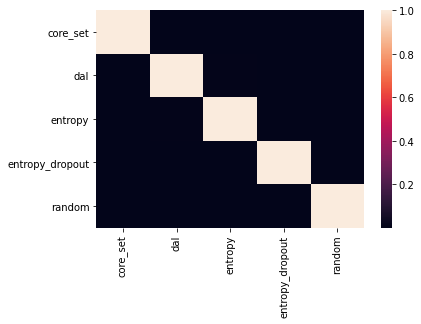

In [78]:
sns.heatmap(lin_vals, xticklabels=df_f.index.get_level_values("sampler"), yticklabels=df_f.index.get_level_values("sampler"));

In [ ]:
for i, row in df_f.iterrows():
    print(row)

In [ ]:
from cka import *

n = 12

lin_vals = np.empty((n, n))
rbf_vals = np.empty((n, n))
    
for i in range(12):
    enc1 = enc_layers[i].detach().cpu().numpy()
    for j in range(i, 12):
        enc2 = enc_layers[j].detach().cpu().numpy()
        lin = linear_CKA(enc1, enc2)
        rbf = kernel_CKA(enc1, enc2)
        lin_vals[i, j] = lin_vals[j, i] = lin
        rbf_vals[i, j] = rbf_vals[j, i] = rbf

In [86]:
from cka import *

n = 18

lin_vals = np.empty((n, n))
rbf_vals = np.empty((n, n))
for i in range(100, 1000, 50):
    A = X[i:i+50]
    print(f"Sample {i//50 - 1}")
    for j in range(i, 1000, 50):
        B = X[j:j+50]
        lin = linear_CKA(A, B)
        rbf = kernel_CKA(A, B)
        i_mod = i // 50 - 2
        j_mod = j // 50 - 2
        lin_vals[i_mod, j_mod] = lin_vals[j_mod, i_mod] = lin
        rbf_vals[i_mod, j_mod] = rbf_vals[j_mod, i_mod] = rbf

Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Sample 6
Sample 7
Sample 8
Sample 9
Sample 10
Sample 11
Sample 12
Sample 13
Sample 14
Sample 15
Sample 16
Sample 17
Sample 18


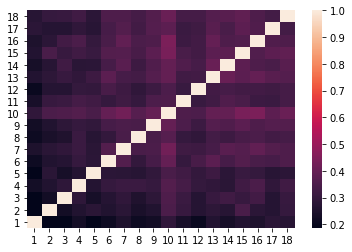

In [90]:
sns.heatmap(np.flip(rbf_vals, 1), xticklabels=range(1, 18+1), yticklabels=range(18, 0, -1));

In [121]:
print(lin_vals)

[[1.         0.98248242 0.96114412 0.95121319 0.90460212 0.71041576
  0.47315452 0.38221755 0.31722107 0.27903575 0.25892686 0.24506719]
 [0.98248242 1.         0.99294096 0.98335407 0.95183908 0.75358897
  0.50744447 0.41371993 0.34471121 0.30324662 0.28150918 0.26641857]
 [0.96114412 0.99294096 1.         0.99445655 0.96767089 0.76605118
  0.51650029 0.42217762 0.3524165  0.31063183 0.28872567 0.27348558]
 [0.95121319 0.98335407 0.99445655 1.         0.97601547 0.78270474
  0.53881083 0.44590866 0.37730722 0.33579883 0.31386207 0.29857912]
 [0.90460212 0.95183908 0.96767089 0.97601547 1.         0.86372819
  0.64402416 0.55500195 0.48563069 0.44082381 0.41642609 0.39986809]
 [0.71041576 0.75358897 0.76605118 0.78270474 0.86372819 1.
  0.91641715 0.85514805 0.80074403 0.7619774  0.73903904 0.72382307]
 [0.47315452 0.50744447 0.51650029 0.53881083 0.64402416 0.91641715
  1.         0.98668085 0.96352048 0.94102505 0.92561751 0.91487866]
 [0.38221755 0.41371993 0.42217762 0.44590866 0.5

In [114]:
print(lin_vals)

[[1.         0.98822128 0.96864577 0.94506764 0.84834738 0.58058964
  0.38203942 0.30834932 0.27336096 0.25623951 0.2498741  0.24393084]
 [0.98822128 1.         0.98886123 0.96045117 0.87905716 0.61475402
  0.41201909 0.33673577 0.30072946 0.28261005 0.27595218 0.26954692]
 [0.96864577 0.98886123 1.         0.9828193  0.90749149 0.63409695
  0.42791082 0.35237271 0.31687092 0.29899749 0.29216579 0.28537392]
 [0.94506764 0.96045117 0.9828193  1.         0.93184827 0.66351566
  0.46338771 0.3904026  0.3567184  0.33894004 0.33143854 0.32377679]
 [0.84834738 0.87905716 0.90749149 0.93184827 1.         0.83521269
  0.66546147 0.5968039  0.55941694 0.53621035 0.52402475 0.51286493]
 [0.58058964 0.61475402 0.63409695 0.66351566 0.83521269 1.
  0.94082216 0.89526446 0.86034934 0.83374846 0.81842072 0.80571088]
 [0.38203942 0.41201909 0.42791082 0.46338771 0.66546147 0.94082216
  1.         0.9877828  0.96883966 0.94919752 0.9360177  0.92503854]
 [0.30834932 0.33673577 0.35237271 0.3904026  0.5

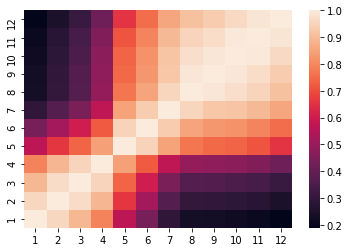

In [26]:
# Random
sns.heatmap(np.flip(lin_vals, 1), xticklabels=range(1, 12+1), yticklabels=range(12, 0, -1));

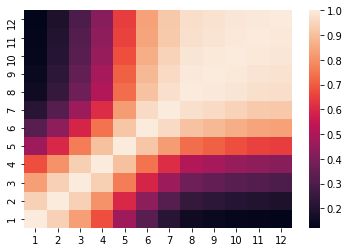

In [33]:
# Core set
sns.heatmap(np.flip(lin_vals, 1), xticklabels=range(1, 12+1), yticklabels=range(12, 0, -1));

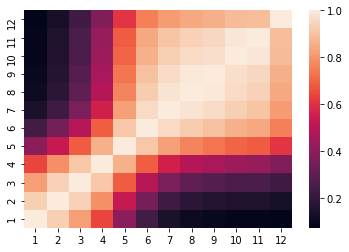

In [38]:
# Entropy
sns.heatmap(np.flip(lin_vals, 1), xticklabels=range(1, 12+1), yticklabels=range(12, 0, -1));

(200.0, 1000.0)

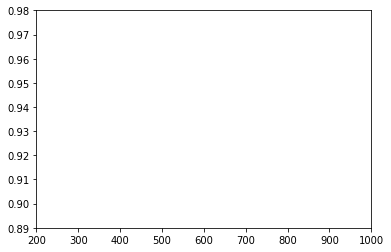

In [9]:
g = sns.lineplot(
    data=df_tr[df_tr.index.get_level_values("mode") == "long-besov"],
    x="labeled",
    y="f1_micro",
    hue="sampler",
    style="sampler",
    markers=True,
    dashes=False,
    ci=95,
    linewidth=3,
)
g.set_ylim(0.89, 0.98)
g.set_xlim(200, 1000)

In [7]:
g = sns.lineplot(
    data=df_tr[df_tr.index.get_level_values("mode") == "ada-besov"],
    x="labeled",
    y="f1_micro",
    hue="sampler",
    style="sampler",
    markers=True,
    dashes=False,
    ci=95,
    linewidth=3,
)
# g.set_ylim(0.82, 0.92)
# g.set_xlim(500, 1000)

ValueError: Could not interpret value `acuraccy` for parameter `y`

In [57]:
from transformers import AutoAdapterModel, AdapterConfig
from datasets import load_dataset

d = load_dataset("glue", "qqp")


# def save_dataset(hfd, name):
#     hfd["train"].to_pandas()[["question1", "question2", "label"]].sample(
#         5_000
#     ).reset_index(drop=True).to_csv(f"data/{name}/train.csv", header=False)
#     hfd["test"].to_pandas()[["question1", "question2", "label"]].sample(
#         2_000
#     ).reset_index(drop=True).to_csv(f"data/{name}/test.csv", header=False)
#     hfd["validation"].to_pandas()[["question1", "question2", "label"]].sample(
#         1_000
#     ).reset_index(drop=True).to_csv(f"data/{name}/validation.csv", header=False)


# save_dataset(d, "QQP")

In [8]:
model = AutoAdapterModel.from_pretrained("bert-base-uncased")
a = model.load_adapter("adapters/TREC-2-BERT-pfeiffer")
model.add_classification_head("head", num_labels=2)
model.add_adapter("head")
model.train_adapter("head")

In [37]:
from datasets import load_dataset
d = load_dataset("glue", "cola")

Reusing dataset glue (/home/jjukic/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [103]:
filt

labeled  train_loss  \
dataset model mode      sampler experiment al_iter                        
SUBJ    BERT  ada       entropy 0          0            100    0.003286   
                                           1            150    0.027270   
                                           2            200    0.013350   
                                           3            250    0.109074   
                                           4            300    0.016562   
...                                                     ...         ...   
              ada-besov dal     0          14           800    0.157853   
                                           15           850    0.015088   
                                           16           900    0.040000   
                                           17           950    0.060457   
                                           18          1000    0.060517   

                                                    test_accuracy  f1_micro  \
dataset model mode      sampler experiment al_iter                            
SUBJ    BERT  ada       entropy 0          0               0.9240    0.9240   
                                           1               0.9335    0.9335   
                                           2               0.9450    0.9450   
                                           3               0.9435    0.9435   
                                           4               0.9305    0.9305   
...                                                           ...       ...   
              ada-besov dal     0          14              0.9495    0.9495   
                                           15              0.9480    0.9480   
                                           16              0.9465    0.9465   
                                           17              0.9460    0.9460   
                                           18              0.9480    0.9480   

                                                    f1_macro  \
dataset model mode      sampler experiment al_iter             
SUBJ    BERT  ada       entropy 0          0        0.923932   
                                           1        0.933425   
                                           2        0.944954   
                                           3        0.943469   
                                           4        0.930201   
...                                                      ...   
              ada-besov dal     0          14       0.949481   
                                           15       0.947985   
                                           16       0.946468   
                                           17       0.945951   
                                           18       0.947991   

                                                                                             selected  
dataset model mode      sampler experiment al_iter                                                     
SUBJ    BERT  ada       entropy 0          0        [2305, 4388, 1686, 4945, 4197, 1651, 1528, 634...  
                                           1        [3930, 1150, 3054, 4473, 4050, 6840, 789, 644,...  
                                           2        [5674, 3296, 6446, 2828, 6228, 4870, 2445, 603...  
                                           3        [95, 4705, 6814, 1339, 2672, 5332, 1333, 2949,...  
                                           4        [3798, 142, 1298, 4842, 2021, 2910, 1488, 3058...  
...                                                                                               ...  
              ada-besov dal     0          14       [2396, 899, 4752, 5165, 2337, 5583, 5158, 4162...  
                                           15       [6091, 4028, 5942, 754, 6482, 2384, 6571, 5384...  
                                           16       [6760, 5142, 4128, 3680, 4473, 4266, 581, 2427...  
                                           17       [4490, 256, 4214, 5

In [60]:
filt = df_tr[df_tr.index.get_level_values("experiment") == 0]
grouped = filt.groupby(["dataset", "model", "mode", "sampler"]).agg(list)
grouped["subsample"] = grouped.selected.apply(lambda x: np.array(x[1:]).ravel())
grouped = grouped[grouped.index.get_level_values("mode") == "ada-besov"]
grouped

labeled  \
dataset model mode      sampler                                                              
COLA    BERT  ada-besov core_set         [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                        dal              [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                        entropy          [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                        entropy_dropout  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                        random           [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   

                                                                                train_loss  \
dataset model mode      sampler                                                              
COLA    BERT  ada-besov core_set         [0.5263520777225494, 0.5369085192680358, 0.001...   
                        dal              [0.5263520777225494, 0.34945824146270754, 0.53...   
                        entropy          [0.5263520777225494, 0.031123188603669406, 0.0...   
                        entropy_dropout  [0.5263520777225494, 0.5394955456256867, 0.553...   
                        random           [0.5263520777225494, 0.46693688035011294, 0.26...   

                                                                             test_accuracy  \
dataset model mode      sampler                                                              
COLA    BERT  ada-besov core_set         [0.6912751677852349, 0.6931927133269415, 0.695...   
                        dal              [0.6912751677852349, 0.6941514860977949, 0.691...   
                        entropy          [0.6912751677852349, 0.6931927133269415, 0.699...   
                        entropy_dropout  [0.6912751677852349, 0.6912751677852349, 0.693...   
                        random           [0.6912751677852349, 0.6931927133269415, 0.698...   

                                                                                  f1_micro  \
dataset model mode      sampler                                                              
COLA    BERT  ada-besov core_set         [0.6912751677852349, 0.6931927133269415, 0.695...   
                        dal              [0.6912751677852349, 0.6941514860977949, 0.691...   
                        entropy          [0.6912751677852349, 0.6931927133269415, 0.699...   
                        entropy_dropout  [0.6912751677852349, 0.6912751677852349, 0.693...   
                        random           [0.6912751677852349, 0.6931927133269415, 0.698...   

                                                                                  f1_macro  \
dataset model mode      sampler                                                              
COLA    BERT  ada-besov core_set         [0.4087301587301587, 0.45069124423963136, 0.52...   
                        dal              [0.4087301587301587, 0.4434765300268128, 0.408...   
                        entropy          [0.4087301587301587, 0.49340036185688435, 0.54...   
                        entropy_dropout  [0.4087301587301587, 0.41171298047953364, 0.41...   
                        random           [0.4087301587301587, 0.4377737349235227, 0.508...   

                                                                                  selected  \
dataset model mode      sampler                                                              
COLA    BERT  ada-besov core_set         [[8231, 3747, 4269, 5631, 1945, 2319, 397, 315...   
                        dal              [[8231, 3747, 4269, 5631, 1945, 2319, 397, 315...   
                        entropy          [[8231, 3747, 4269, 5631, 1945, 2319, 397, 315...   
                        entropy_dropout  [[8231, 3747, 4269, 5631, 1945, 2319, 397, 315...   
                        random           [[8231, 3747, 4269, 5631, 1945, 2319, 397, 315...   

                                                                                 subsample  
dataset model mode      sampler     

In [146]:
sampler = "random"
df_i = maj_df[(maj_df.sampler==sampler)]
df_i[df_i.forgetfulness==1].pvi

6165    0.986709
521     1.012730
549     0.986849
1202    0.151575
3977    0.986847
2740    0.986856
1147    0.986786
4501    1.013089
6035    1.012707
2966   -9.133169
3435    1.009307
1410    0.985960
313     1.013238
4190    1.013241
6053    0.961839
5071    0.986864
3825    1.013227
2816    1.012418
5332    0.986841
5563    0.909505
1402    0.986689
2132    0.986845
5651    0.986851
6235    0.986832
3785    0.986646
373     1.013114
2290    0.986717
1396    0.986862
1602    0.986829
4129    1.013235
1279    0.986163
5638    0.939564
5188    1.013167
3719    0.518692
239     1.013236
1080    0.986765
6219    0.986837
3732    0.986857
5641    0.986562
3177    0.986848
3540    1.008838
229    -9.642583
987     0.984621
4214    1.013194
4113    0.986840
4394    0.986834
6321    0.986850
1093    0.986610
6017    0.986680
1643    1.012312
1789    0.986861
5979    1.012984
2913    0.925483
5164    1.012201
4166    1.013243
2625    1.013203
980     0.986664
319     1.013184
2485    0.9757

In [140]:
d = df_i[df_i.forgetfulness==2]
# d[d.pvi < 0]
d

,correctness,confidence,variability,forgetfulness,threshold_closeness,pvi,text,label,type,sampler
1475,17,0.844087,0.295359,2,0.131604,1.013235,is life a series of uncontrollable events that...,objective,M,entropy
3,17,0.863309,0.268679,2,0.118007,1.013234,showing this beautiful city as seen through th...,objective,M,entropy
6707,18,0.832672,0.271331,2,0.139329,-0.849927,"in this vivid , emotionally complex ensemble p...",subjective,E,entropy
508,17,0.770754,0.248188,2,0.176692,0.986356,". . . with "" the bourne identity "" we return ...",subjective,M,entropy
1930,16,0.829752,0.305369,2,0.141264,1.013243,"capitalizing on his fame as the star of "" hoga...",objective,M,entropy
...,...,...,...,...,...,...,...,...,...,...
4941,17,0.829025,0.256406,2,0.141743,0.986773,the animated subplot keenly depicts the inner ...,subjective,M,entropy
1251,18,0.867831,0.208241,2,0.114700,0.985474,"a full experience , a love story and a murder ...",subjective,E,entropy
511,15,0.796976,0.301658,2,0.161806,1.013214,john has become not just a full fledged phenom...,objective,M,entropy
3901,12,0.604527,0.469929,2,0.239074,0.986836,russian ark is a new treasure of the hermitage .,subjective,H,entropy


In [147]:
df_i["correct"] = df_i.correctness

<ipython-input-147-1dd16cd21e0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i["correct"] = df_i.correctness


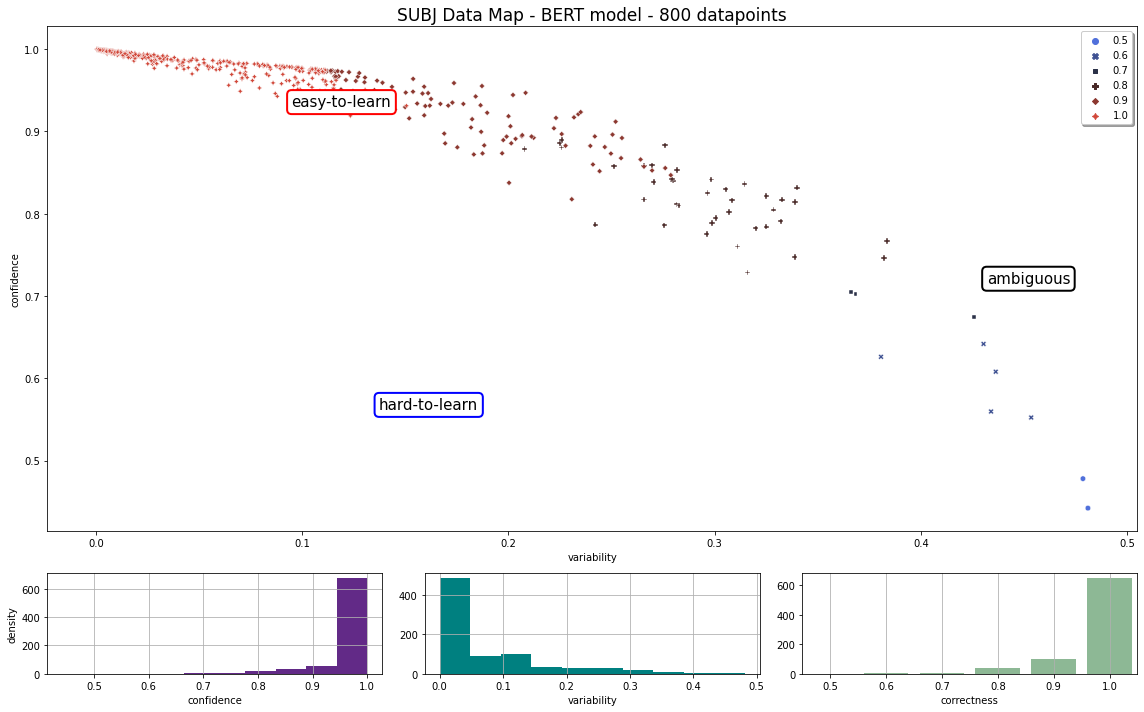

In [148]:
scatter_it(df_i, meta={"dataset": "SUBJ", "model": "BERT"});

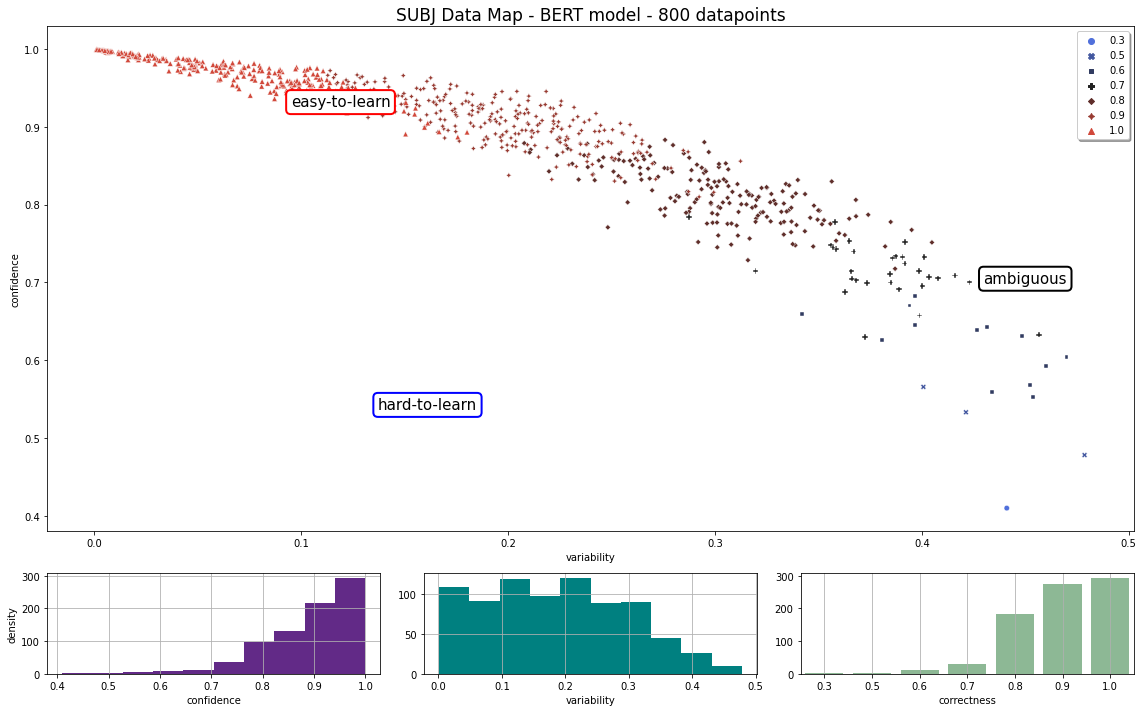

In [145]:
scatter_it(df_i, meta={"dataset": "SUBJ", "model": "BERT"});

<AxesSubplot:>

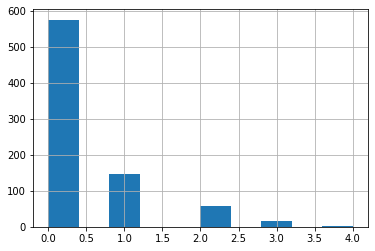

In [119]:
maj_df[(maj_df.sampler=="dal")].forgetfulness.hist()

<AxesSubplot:>

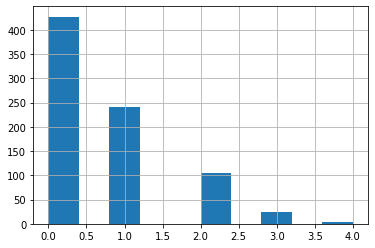

In [120]:
maj_df[(maj_df.sampler=="entropy")].forgetfulness.hist()

<AxesSubplot:>

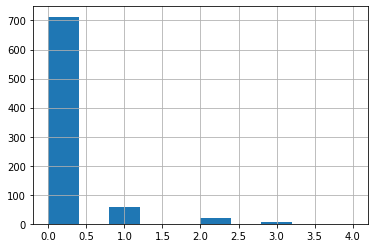

In [121]:
maj_df[(maj_df.sampler=="random")].forgetfulness.hist()

In [50]:
maj_df[(maj_df.sampler=="entropy_dropout")].forgetfulness.value_counts()

0       542
1       219
2        92
3        34
4         9
5         3
1000      1
Name: forgetfulness, dtype: int64

In [51]:
df = maj_df[(maj_df.sampler=="entropy_dropout")]
df = df[df.forgetfulness < 10]

<AxesSubplot:>

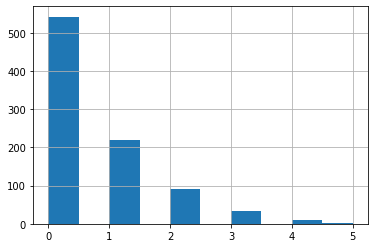

In [53]:
df.forgetfulness.hist()

In [61]:
def get_type(x):
    x = x / 20
    if x < 0.5:
        return "I"
    if x < 0.75:
        return "H"
    if x < 0.9:
        return "M"
    return "E"
    

df["type"] = df.correctness.apply(lambda x: get_type(x))

dfs = []
for index, row in grouped.iterrows():
    sampler = index[3]
    print(sampler)
    indices = row["subsample"]
    df_sampler = df.loc[indices]
    df_sampler["sampler"] = sampler
    dfs.append(df_sampler)
#     g = sns.histplot(data=df_sampler, x="pvi", linewidth=3, hue="sampler")

maj_df = pd.concat(dfs)




core_set
dal
entropy
entropy_dropout
random


In [92]:
filtered = grouped[grouped]

labeled  \
dataset model adapter tapta sampler  experiment mode                                                      
SUBJ    BERT  fft     False core_set 0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                                last  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                     1          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                                last  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                     2          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
...                                                                                                 ...   
              unipelt True  random   2          last  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                     3          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                                last  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                     4          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                                                last  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   

                                                                                             train_loss  \
dataset model adapter tapta sampler  experiment mode                                                      
SUBJ    BERT  fft     False core_set 0          best  [0.05477863736450672, 0.12032186836004258, 0.0...   
                                                last  [0.05477863736450672, 0.015543065778911114, 0....   
                                     1          best  [0.10588858276605606, 0.024101626127958298, 0....   
                                                last  [0.08393486868590117, 0.034584060311317444, 0....   
                                     2          best  [0.07019390910863876, 0.009657853282988071, 0....   
...                                                                                                 ...   
              unipelt True  random   2          last  [0.00028843421023339033, 0.0002357221761485561...   
                                     3          best  [0.00028132412262493744, 0.01980016430024989, ...   
                                                last  [0.00028132412262493744, 0.0003146255854517221...   
                                     4          best  [0.003631269559264183, 0.0005351206171326339, ...   
                                                last  [0.0006057980135665275, 0.00020836981711909176...   

                                                                                          test_accuracy  \
dataset model adapter tapta sampler  experiment mode                                                      
SUBJ    BERT  fft     False core_set 0          best  [0.8895, 0.9055, 0.9175, 0.9195, 0.9355, 0.927...   
                                                last  [0.8895, 0.903, 0.9175, 0.9195, 0.9335, 0.9205...   
                                     1          best  [0.86, 0.913, 0.924, 0.931, 0.9365, 0.924, 0.9...   
                                                last  [0.828, 0.91, 0.92, 0.9305, 0.935, 0.919, 0.93...   
                                     2          best  [0.863, 0.9065, 0.8935, 0.901, 0.922, 0.9315, ...   
...                                                                                                 ...   
              unipelt True  random   2          last  [0.9185, 0.915, 0.927, 0.9235, 0.931, 0.908, 0...   
                                     3          best  [0.9085, 0.934, 0.9295, 0.9355, 0.938, 0.942, ...   
                                                last  [0.9085, 0.923, 0.9205, 0.933, 0.933, 0.941, 0...   
                                     4          best  [0.9315, 0.9335, 0.9375, 0.9305, 0.9415, 0.949...   
                            

In [275]:
ed = maj_df[maj_df.sampler=="random"]
indices = ed.index.tolist()

In [251]:
in

,correctness,confidence,variability,forgetfulness,threshold_closeness,pvi,text,label,type,sampler
4022,18,0.874810,0.275991,0,0.109518,2.095959,What were millions of kids wearing on their he...,1,E,entropy_dropout
3891,19,0.905251,0.193326,1,0.085771,1.693314,What was the worst hurricane ?,1,E,entropy_dropout
1695,19,0.944441,0.183099,0,0.052472,2.692248,What is George Lucas 's e-mail address ?,5,E,entropy_dropout
3820,18,0.853758,0.291852,0,0.124855,2.229052,"What was the claim to fame of Explorer I , lau...",0,E,entropy_dropout
1854,18,0.870147,0.279845,1,0.112991,2.689060,What is the US Federal Government website for ...,5,E,entropy_dropout
...,...,...,...,...,...,...,...,...,...,...
4563,20,0.985462,0.057802,0,0.014327,2.098110,What soft drink held a national flavor poll in...,1,E,random
1170,19,0.948653,0.178335,0,0.048710,2.096786,What animals did The Amazing Three masquerade ...,1,E,random
3120,19,0.856379,0.177757,1,0.122994,2.229073,What is Doegs ?,0,E,random
10,19,0.953862,0.186484,0,0.044009,2.229162,Why do heavier objects travel downhill faster ?,0,E,random


In [253]:
ed.forgetfulness.value_counts()

0    529
1    224
2    101
3     34
4      8
5      4
Name: forgetfulness, dtype: int64

In [122]:
df.corr()

,correctness,confidence,variability,forgetfulness,threshold_closeness,pvi
correctness,1.000000,0.957830,-0.838666,-0.675397,-0.892643,0.090499
confidence,0.957830,1.000000,-0.900898,-0.693663,-0.955525,0.105815
variability,-0.838666,-0.900898,1.000000,0.691500,0.961746,-0.105719
forgetfulness,-0.675397,-0.693663,0.691500,1.000000,0.736075,-0.094602
threshold_closeness,-0.892643,-0.955525,0.961746,0.736075,1.000000,-0.112207
pvi,0.090499,0.105815,-0.105719,-0.094602,-0.112207,1.000000


In [166]:
maj_df["imp"] = maj_df.confidence * maj_df.variability

In [26]:
maj_df[maj_df.sampler == "random"].type.value_counts()

E    657
M    139
H      4
Name: type, dtype: int64

In [27]:
maj_df[maj_df.sampler == "entropy_dropout"].type.value_counts()

E    659
M    136
H      3
I      2
Name: type, dtype: int64

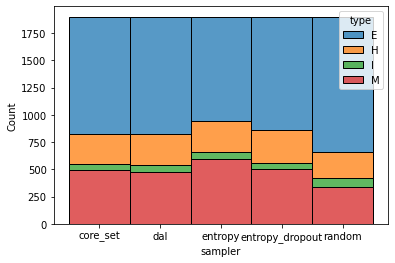

In [62]:
g = sns.histplot(data=maj_df, x="sampler", hue="type", multiple="stack")
# g.set_xlim((-8, 0))
# g.set_ylim((0, 10))

In [154]:
maj_df[maj_df.sampler == "random"].type.value_counts()

E    775
M    182
H     43
Name: type, dtype: int64

In [152]:
maj_df[maj_df.sampler == "entropy"].type.value_counts()

E    739
M    226
H     33
I      2
Name: type, dtype: int64

<AxesSubplot:xlabel='forgetfulness', ylabel='Count'>

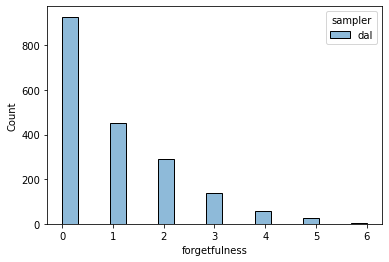

In [65]:
sns.histplot(data=maj_df[(maj_df.sampler == "dal") & (maj_df.forgetfulness < 1000)], x="forgetfulness", hue="sampler")

In [164]:
d = maj_df[maj_df.sampler == "entropy"]
d.sort_values("forgetfulness")[-20:]

,correctness,confidence,variability,forgetfulness,threshold_closeness,pvi,text,label,type,sampler
4216,11,0.590434,0.318435,5,0.241822,-3.341225,The committee has all now resigned.,0,H,entropy
755,15,0.703591,0.280328,5,0.208551,0.504477,They represented Mary seriously to the dean as...,1,M,entropy
1825,9,0.475841,0.316549,5,0.249416,0.399537,"I said that my father, he was tight as an owl.",1,I,entropy
5285,14,0.665640,0.260819,5,0.222563,0.115586,How likely to win is he?,1,H,entropy
7608,8,0.402739,0.355467,5,0.240540,1.756632,Whom left Bill.,0,I,entropy
7649,15,0.700617,0.290723,5,0.209753,0.320450,for John to hurt himself is stupid.,1,M,entropy
6477,13,0.603425,0.356849,5,0.239303,0.502094,Those days Bill offered Mary anything he cooked.,1,H,entropy
1833,12,0.527580,0.243685,5,0.249239,0.413335,"My father, that he's lived here all his life i...",1,H,entropy
5389,14,0.608003,0.275256,5,0.238335,-1.813283,She has enough problems as it is.,1,H,entropy
7559,8,0.374484,0.300274,5,0.234246,1.663690,Bill likes herself.,0,I,entropy


In [168]:
filtered = grouped[(grouped.index.get_level_values("sampler") == "entropy")
    & (grouped.index.get_level_values("tapta") == False)
    & (grouped.index.get_level_values("experiment") == 0)
    & (grouped.index.get_level_values("mode") == "best")
    & (grouped.index.get_level_values("adapter").isin(["fft", "unipelt"]))]

In [169]:
filtered

labeled  \
dataset model adapter tapta sampler experiment mode                                                      
SUBJ    BERT  fft     False entropy 0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
              unipelt False entropy 0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   

                                                                                            train_loss  \
dataset model adapter tapta sampler experiment mode                                                      
SUBJ    BERT  fft     False entropy 0          best  [0.05477863736450672, 0.08387928456068039, 0.0...   
              unipelt False entropy 0          best  [0.0017790999700082466, 0.0005098180670756846,...   

                                                                                         test_accuracy  \
dataset model adapter tapta sampler experiment mode                                                      
SUBJ    BERT  fft     False entropy 0          best  [0.8895, 0.8965, 0.923, 0.931, 0.923, 0.935, 0...   
              unipelt False entropy 0          best  [0.9155, 0.9005, 0.932, 0.938, 0.9375, 0.9415,...   

                                                                                              f1_micro  \
dataset model adapter tapta sampler experiment mode                                                      
SUBJ    BERT  fft     False entropy 0          best  [0.8895, 0.8965, 0.923, 0.931, 0.923, 0.935, 0...   
              unipelt False entropy 0          best  [0.9155, 0.9005, 0.932, 0.938, 0.9375, 0.9415,...   

                                                                                              f1_macro  \
dataset model adapter tapta sampler experiment mode                                                      
SUBJ    BERT  fft     False entropy 0          best  [0.8892061470033897, 0.8964987321094684, 0.922...   
              unipelt False entropy 0          best  [0.9154160715970422, 0.9004790757256713, 0.931...   

                                                                                              selected  \
dataset model adapter tapta sampler experiment mode                                                      
SUBJ    BERT  fft     False entropy 0          best  [[2305, 4388, 1686, 4945, 4197, 1651, 1528, 63...   
              unipelt False entropy 0          best  [[2305, 4388, 1686, 4945, 4197, 1651, 1528, 63...   

                                                                                                sample  
dataset model adapter tapta sampler experiment mode                                                     
SUBJ    BERT  fft     False entropy 0          best  [1094, 6951, 1100, 3764, 2808, 5754, 5043, 561...  
              unipelt False entropy 0          best  [6983, 1260, 4453, 5791, 1074, 3914, 406, 5846...

In [183]:
mdf.corr()

,correctness,confidence,variability,forgetfulness,threshold_closeness,pvi
correctness,1.000000,0.949361,-0.897584,-0.624351,-0.926094,0.036519
confidence,0.949361,1.000000,-0.931015,-0.646512,-0.986136,0.046357
variability,-0.897584,-0.931015,1.000000,0.641730,0.958425,-0.051715
forgetfulness,-0.624351,-0.646512,0.641730,1.000000,0.673285,-0.060791
threshold_closeness,-0.926094,-0.986136,0.958425,0.673285,1.000000,-0.051556
pvi,0.036519,0.046357,-0.051715,-0.060791,-0.051556,1.000000


<AxesSubplot:xlabel='confidence', ylabel='Count'>

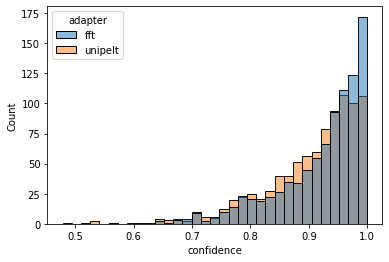

In [185]:
sns.histplot(data=mdf, x="confidence", hue="adapter", multiple="layer")

In [171]:
dfs = []

for i, row in filtered.iterrows():
    df_i = df.iloc[row["sample"]]
    df_i["adapter"] = str(i[2])
    dfs.append(df_i)

mdf = pd.concat(dfs)
mdf

<ipython-input-171-81a74b7f9e9a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i["adapter"] = str(i[2])


,correctness,confidence,variability,forgetfulness,threshold_closeness,pvi,text,label,adapter
1094,20,0.979503,0.056840,0,0.020077,0.986853,"on top of a foundering performance , [madonna'...",subjective,fft
6951,20,0.997283,0.006102,0,0.002710,0.986853,"the art direction is often exquisite , and the...",subjective,fft
1100,20,0.967766,0.105718,0,0.031195,0.986861,"who , exactly , is fighting whom here ? ah , y...",subjective,fft
3764,20,0.995790,0.011326,0,0.004192,0.986858,"tunney , brimming with coltish , neurotic ener...",subjective,fft
2808,20,0.993920,0.018371,0,0.006043,0.986860,nothing short of wonderful with its ten-year-o...,subjective,fft
...,...,...,...,...,...,...,...,...,...
1581,20,0.957722,0.118571,0,0.040490,1.013195,patricia gets increasingly unhappy within the ...,objective,unipelt
2819,19,0.896480,0.220965,0,0.092803,0.986631,an unusual and compelling chinese film about t...,subjective,unipelt
2830,19,0.906578,0.194316,0,0.084694,0.986738,bella is the picture of health with boundless ...,subjective,unipelt
1557,16,0.795705,0.271914,2,0.162559,1.008674,seeing these old cars in recent films and phot...,objective,unipelt


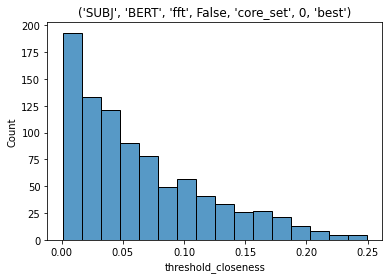

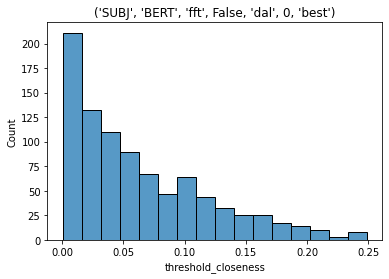

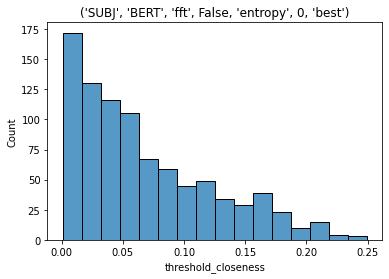

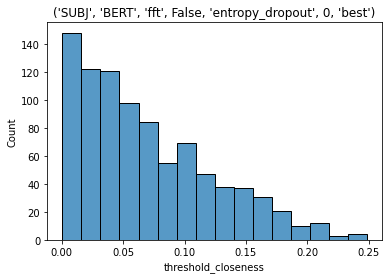

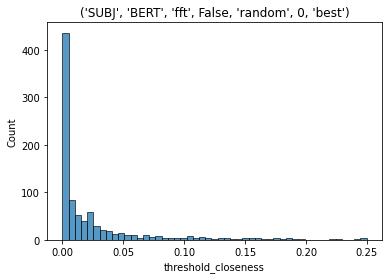

In [126]:
for i, row in filtered.iterrows():
    df_i = df.iloc[row["sample"]]
    sns.histplot(df_i, x="threshold_closeness")
    plt.title(i)
    plt.show()

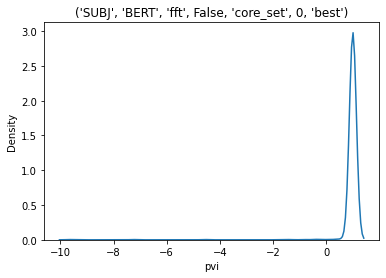

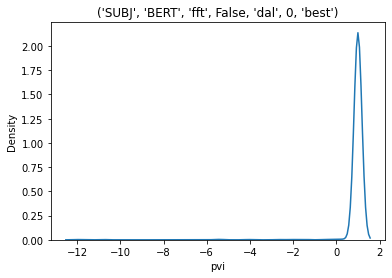

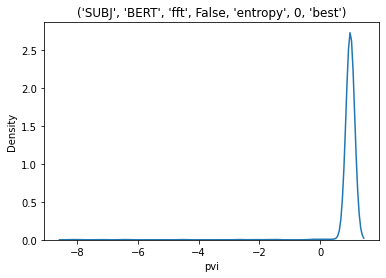

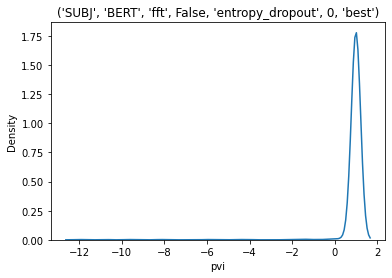

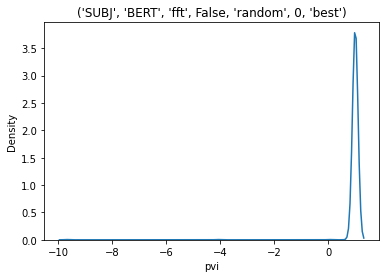

In [118]:
for i, row in filtered.iterrows():
    df_i = df.iloc[row["sample"]]
    sns.kdeplot(data=df_i, x="pvi")
    plt.title(i)
    plt.show()

In [142]:
:df.type.value_counts()

E    6763
M    1476
H     275
I      37
Name: type, dtype: int64

In [82]:
df.forgetfulness.value_counts()

0    6289
1     499
2     166
3      40
4       6
Name: forgetfulness, dtype: int64

In [83]:
df

labeled  \
dataset model adapter tapta sampler         experiment mode                                                      
SUBJ    BERT  fft     False core_set        0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                            dal             0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                            entropy         0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                            entropy_dropout 0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   
                            random          0          best  [100, 150, 200, 250, 300, 350, 400, 450, 500, ...   

                                                                                                    train_loss  \
dataset model adapter tapta sampler         experiment mode                                                      
SUBJ    BERT  fft     False core_set        0          best  [0.05477863736450672, 0.12032186836004258, 0.0...   
                            dal             0          best  [0.05477863736450672, 0.00941129568964243, 0.0...   
                            entropy         0          best  [0.05477863736450672, 0.08387928456068039, 0.0...   
                            entropy_dropout 0          best  [0.05477863736450672, 0.013379470631480216, 0....   
                            random          0          best  [0.05477863736450672, 0.045682889968156816, 0....   

                                                                                                 test_accuracy  \
dataset model adapter tapta sampler         experiment mode                                                      
SUBJ    BERT  fft     False core_set        0          best  [0.8895, 0.9055, 0.9175, 0.9195, 0.9355, 0.927...   
                            dal             0          best  [0.8895, 0.9215, 0.9105, 0.924, 0.917, 0.9295,...   
                            entropy         0          best  [0.8895, 0.8965, 0.923, 0.931, 0.923, 0.935, 0...   
                            entropy_dropout 0          best  [0.8895, 0.9275, 0.9195, 0.9305, 0.9315, 0.909...   
                            random          0          best  [0.8895, 0.9165, 0.915, 0.915, 0.917, 0.9205, ...   

                                                                                                      f1_micro  \
dataset model adapter tapta sampler         experiment mode                                                      
SUBJ    BERT  fft     False core_set        0          best  [0.8895, 0.9055, 0.9175, 0.9195, 0.9355, 0.927...   
                            dal             0          best  [0.8895, 0.9215, 0.9105, 0.924, 0.917, 0.9295,...   
                            entropy         0          best  [0.8895, 0.8965, 0.923, 0.931, 0.923, 0.935, 0...   
                            entropy_dropout 0          best  [0.8895, 0.9275, 0.9195, 0.9305, 0.9315, 0.909...   
                            random          0          best  [0.8895, 0.9165, 0.915, 0.915, 0.917, 0.9205, ...   

                                                                                                      f1_macro  \
dataset model adapter tapta sampler         experiment mode                                                      
SUBJ    BERT  fft     False core_set        0          best  [0.8892061470033897, 0.9053447417125942, 0.917...   
                            dal             0          best  [0.8892061470033897, 0.9214811358428863, 0.910...   
                            entropy         0          best  [0.8892061470033897, 0.8964987321094684, 0.922...   
                            entropy_dropout 0          best  [0.8892061470033897, 0.927499546872168, 0.9194...   
                            random          0          best  [0.8892061470033897, 0.916382412767955, 0.9149...   

                                                                                                      select

In [104]:
maj_df[maj_df.sampler == "entropy"].pvi

1475    1.013235
3       1.013234
3725    1.013193
6073    1.013177
2768    0.986857
          ...   
6829    1.013242
2707    0.986793
4922    0.986847
1549    1.012873
3510    0.986838
Name: pvi, Length: 800, dtype: float64

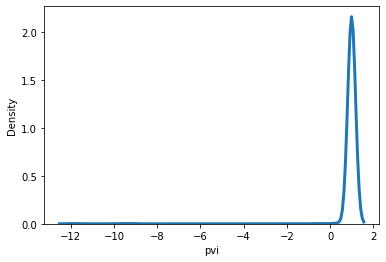

In [99]:
g = sns.kdeplot(data=maj_df[maj_df.sampler == "random"], x="pvi", linewidth=3)

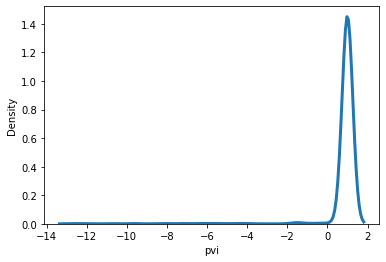

In [101]:
g = sns.kdeplot(data=maj_df[maj_df.sampler == "entropy"], x="pvi", linewidth=3)

In [26]:
from cleanlab.classification import CleanLearning
from cleanlab.filter import find_label_issues

# # Option 1 - works with sklearn-compatible models - just input the data and labels ツ
# label_issues_info = CleanLearning(clf=sklearn_compatible_model).find_label_issues(data, labels)

# # Option 2 - works with ANY ML model - just input the model's predicted probabilities
# ordered_label_issues = find_label_issues(
#     labels=labels,
#     pred_probs=pred_probs,  # predicted probabilities from any model (ideally out-of-sample predictions)
#     return_indices_ranked_by='self_confidence',
# )

In [21]:
train_eval = make_iterable(
    train,
    device,
    batch_size=args.batch_size,
)

In [33]:
eval_result_dict, probs, labels = evaluate_model(model=model, tokenizer=tokenizer, data=train_eval)

[Accuracy]: 4823/500 : 964.600%onds
[F1-micro]: 0.988
[F1-macro]: 0.975
[[1117    0   13    0   10    0]
 [   3 1116    1    0    0    0]
 [   6    0 1026    1    2    6]
 [   1    2    3  748    1    0]
 [   0    0    0    0  748    0]
 [   2    0    7    0    0   68]]


In [34]:
ordered_label_issues = find_label_issues(
    labels=labels.numpy(),
    pred_probs=probs.cpu().numpy(),  # predicted probabilities from any model (ideally out-of-sample predictions)
    return_indices_ranked_by='self_confidence',
)

In [37]:
train[ordered_label_issues].examples

[Example({
     id: (None, 1694),
     text: (None, ['what', 'is', 'the', 'largest', 'variety', 'of', 'cactus', '?']),
     label: (None, 0)
 }),
 Example({
     id: (None, 2501),
     text: (None, ['how', 'do', 'you', 'say', ',', '`', '`', 'i', 'love', 'you', "'", "'", 'in', 'other', 'languages', '?']),
     label: (None, 1)
 }),
 Example({
     id: (None, 1704),
     text: (None, ['what', 'is', 'the', 'connection', 'between', 'new', 'k', '##ry', '##pton', 'and', 'dax', '##am', '?']),
     label: (None, 1)
 }),
 Example({
     id: (None, 479),
     text: (None, ['how', 'do', 'you', 'say', '`', '`', 'fresh', "'", "'", 'in', 'spanish', '?']),
     label: (None, 1)
 }),
 Example({
     id: (None, 4038),
     text: (None, ['how', 'do', 'you', 'say', '`', '`', 'eat', 'the', 'day', "'", "'", 'in', 'latin', '?']),
     label: (None, 1)
 }),
 Example({
     id: (None, 648),
     text: (None, ['how', 'do', 'you', 'say', 'i', 'love', 'you', 'in', 'spanish', '?']),
     label: (None, 1)
 }),
 Ex

In [39]:
from cleanlab.dataset import health_summary

health_summary(labels.numpy(), probs.cpu().numpy(), class_names=["0", "1", "2", "3", "4", "5"])

----------------------------------------------------------
|  Generating a Cleanlab Dataset Health Summary          |
|   for your dataset with 4,881 examples and 6 classes.  |
|  Note, Cleanlab is not a medical doctor... yet.        |
----------------------------------------------------------

Overall Class Quality and Noise across your dataset (below)
------------------------------------------------------------ 



,Class Name,Class Index,Label Issues,Inverse Label Issues,Label Noise,Inverse Label Noise,Label Quality Score
0,2,2,7,7,0.006724,0.006724,0.993276
1,0,0,7,3,0.006140,0.002641,0.993860
2,1,1,0,0,0.000000,0.000000,1.000000
3,3,3,0,0,0.000000,0.000000,1.000000
4,4,4,0,0,0.000000,0.000000,1.000000
5,5,5,0,4,0.000000,0.049383,1.000000



Class Overlap. In some cases, you may want to merge classes in the top rows (below)
-----------------------------------------------------------------------------------



,Class Name A,Class Name B,Class Index A,Class Index B,Num Overlapping Examples,Joint Probability
0,0,2,0,2,10,0.002049
1,2,5,2,5,4,0.000820
2,0,1,0,1,0,0.000000
3,0,3,0,3,0,0.000000
4,0,4,0,4,0,0.000000
5,0,5,0,5,0,0.000000
6,1,2,1,2,0,0.000000
7,1,3,1,3,0,0.000000
8,1,4,1,4,0,0.000000
9,1,5,1,5,0,0.000000



 * Overall, about 0% (14 of the 4,881) labels in your dataset have potential issues.
 ** The overall label health score for this dataset is: 1.00.

Generated with <3 from Cleanlab.



{'overall_label_health_score': 0.9971317353001435,
 'joint': array([[0.23212456, 0.        , 0.00143413, 0.        , 0.        ,
         0.        ],
        [0.        , 0.22946118, 0.        , 0.        , 0.        ,
         0.        ],
        [0.00061463, 0.        , 0.21184184, 0.        , 0.        ,
         0.0008195 ],
        [0.        , 0.        , 0.        , 0.15468142, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.15324729,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.01577546]]),
 'classes_by_label_quality':   Class Name  Class Index  Label Issues  Inverse Label Issues  Label Noise  \
 0          2            2             7                     7     0.006724   
 1          0            0             7                     3     0.006140   
 2          1            1             0                     0     0.000000   
 3          3            3             0        

In [60]:
from cleanlab.outlier import OutOfDistribution

ood = OutOfDistribution()

# To get outlier scores for train_data using predicted class probabilities (from a trained classifier) and given class labels
ood_train_predictions_scores = ood.fit_score(pred_probs=probs.cpu().numpy(), labels=labels.numpy())

# To get outlier scores for additional test_data using predicted class probabilities
# ood_test_predictions_scores = ood.score(pred_probs=test_pred_probs)

Fitting OOD estimator based on provided pred_probs ...


In [66]:
ind = np.argpartition(ood_train_predictions_scores, -30)[-30:]

In [67]:
train[ind].examples

[Example({
     id: (None, 668),
     text: (None, ['what', 'is', 'the', 'abbreviated', 'expression', 'for', 'the', 'national', 'bureau', 'of', 'investigation', '?']),
     label: (None, 2)
 }),
 Example({
     id: (None, 3959),
     text: (None, ['what', 'does', 's', '##na', '##fu', 'stand', 'for', '?']),
     label: (None, 2)
 }),
 Example({
     id: (None, 2085),
     text: (None, ['what', 'does', 'the', '`', '`', 'c', "'", "'", 'stand', 'for', 'in', 'the', 'equation', 'e', '=', 'mc', '##2', '?']),
     label: (None, 2)
 }),
 Example({
     id: (None, 30),
     text: (None, ['what', 'does', 'the', 'abbreviation', 'aids', 'stand', 'for', '?']),
     label: (None, 2)
 }),
 Example({
     id: (None, 1396),
     text: (None, ['what', 'does', 'e', '.', 'g', '.', 'stand', 'for', '?']),
     label: (None, 2)
 }),
 Example({
     id: (None, 518),
     text: (None, ['what', 'does', 'sid', '##s', 'stand', 'for', '?']),
     label: (None, 2)
 }),
 Example({
     id: (None, 1349),
     text: (N